In [35]:
import os
import numpy as np
import librosa
import librosa.display
import scipy.signal
import matplotlib.pyplot as plt

PRE-PROCESSING

In [36]:
def read_and_process(file_path):

    # upload audio file
    y, sr = librosa.load(file_path, sr=None)
    y = librosa.util.normalize(y)           
    
    # show audio signal
    plt.figure(figsize=(30, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Audio signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Apply a low-pass filter
    nyquist = sr / 2
    cutoff = 3000  # cut frequency
    b, a = scipy.signal.butter(5, cutoff / nyquist, btype='low')
    filtered_y = scipy.signal.filtfilt(b, a, y)

    # show filtered audio signal
    plt.figure(figsize=(30, 4))
    plt.plot(filtered_y)
    plt.title('Filtered signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    return filtered_y, sr

Features extraction on processed data

In [37]:
def extract_mfcc(file_path):
    
    y, sr = read_and_process(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 MFCC

     # show MFCC
    plt.figure(figsize=(30, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.show()
    
    return np.mean(mfcc, axis=1)  # MFCC mean on all time windows 


Fuction that automatically labels datas

In [38]:
def create_labels_and_features(file_paths, speaker_id):
    features = []
    labels = []
    
    for file_path in file_paths:
        mfcc_features = extract_mfcc(file_path)  # MFCC extraction
        features.append(mfcc_features)
        labels.append(speaker_id) 
    
    return np.array(features), np.array(labels)

MODEL TRAINING

Function to generate audio file paths

In [39]:
def generate_audio_file_paths(base_name, num_files):
    return [f"dataset/raw/{base_name}_pw{i}.wav" for i in range(1, num_files + 1)]

arianna_files = generate_audio_file_paths('arianna', 8)
andre_files = generate_audio_file_paths('andre', 9) 

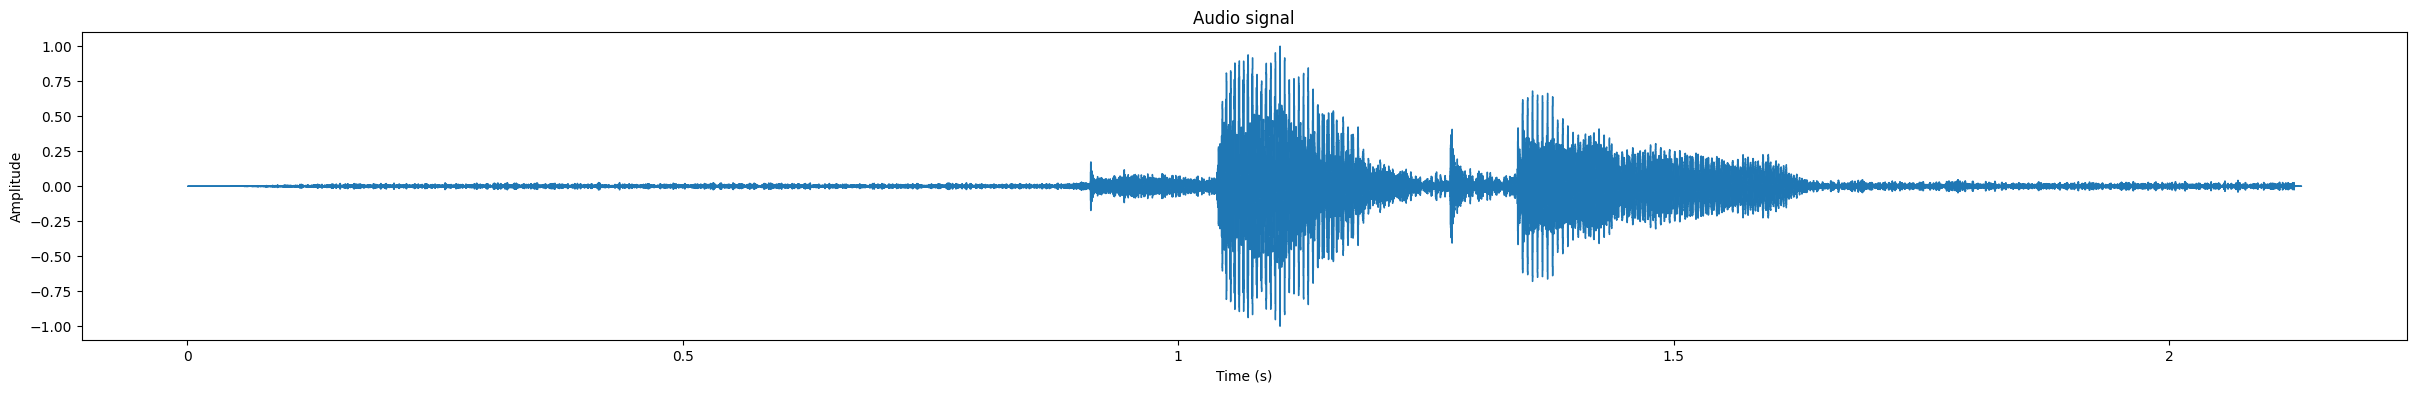

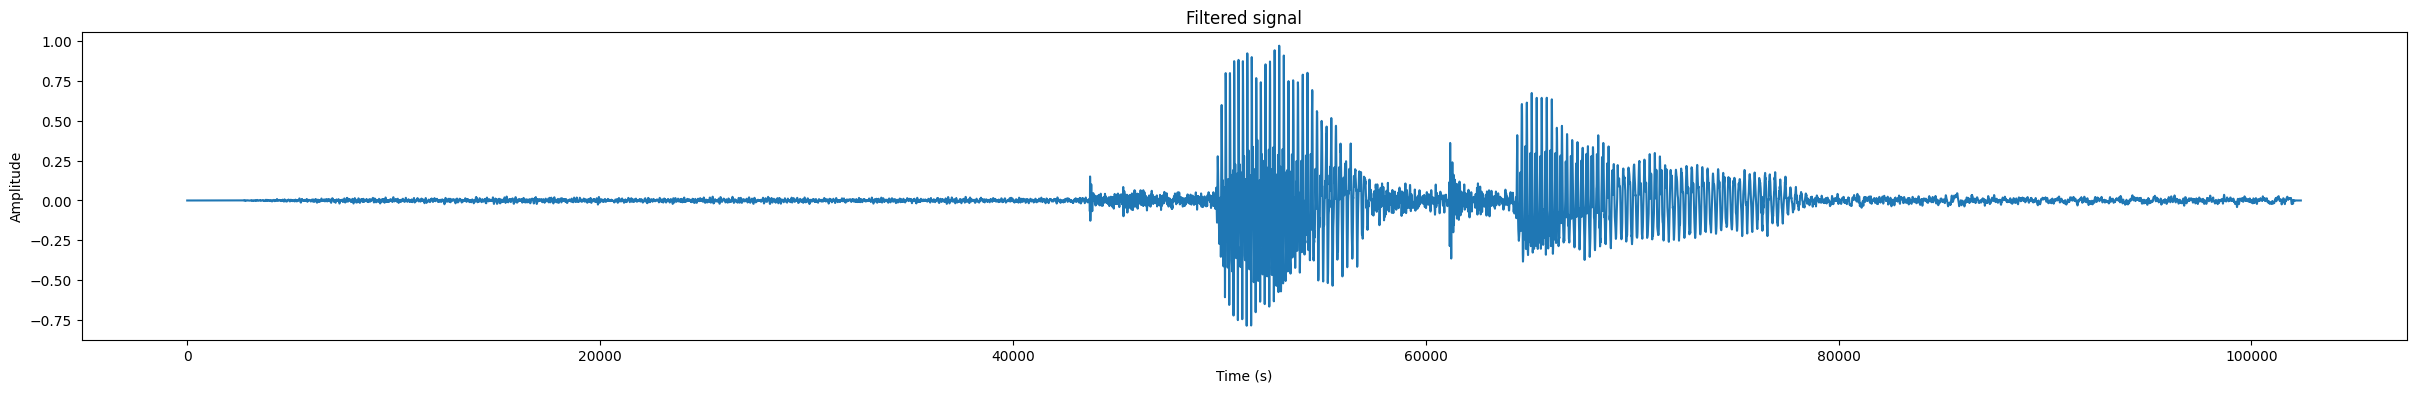

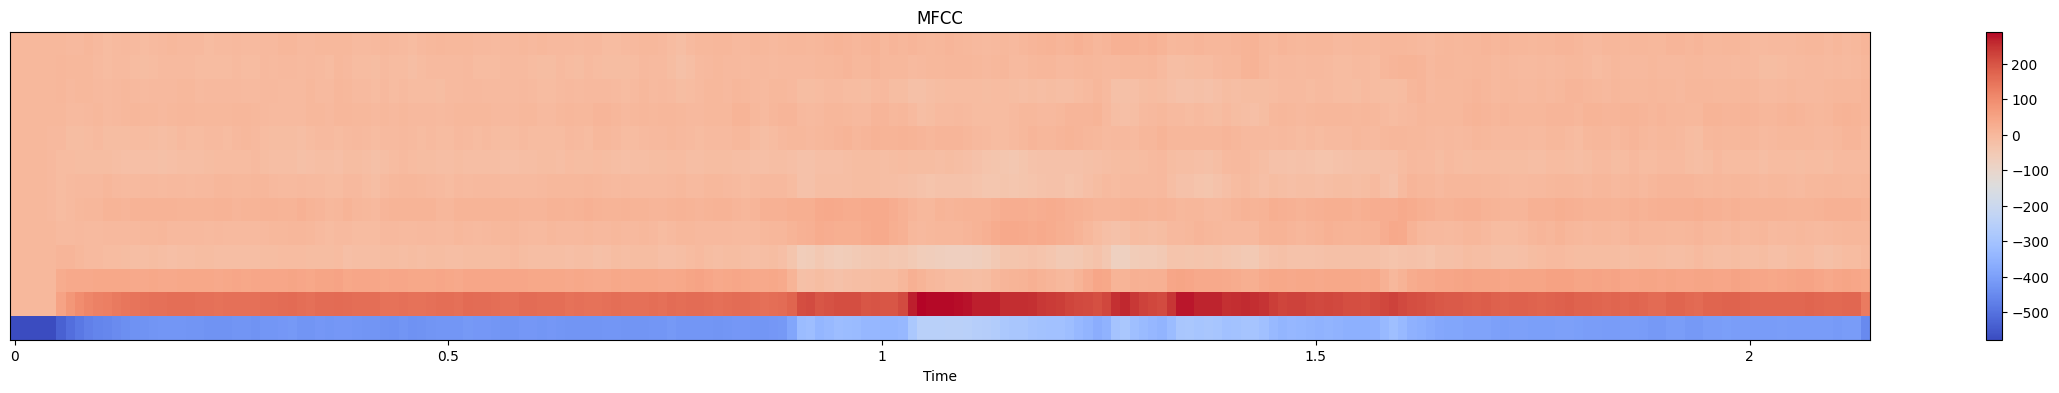

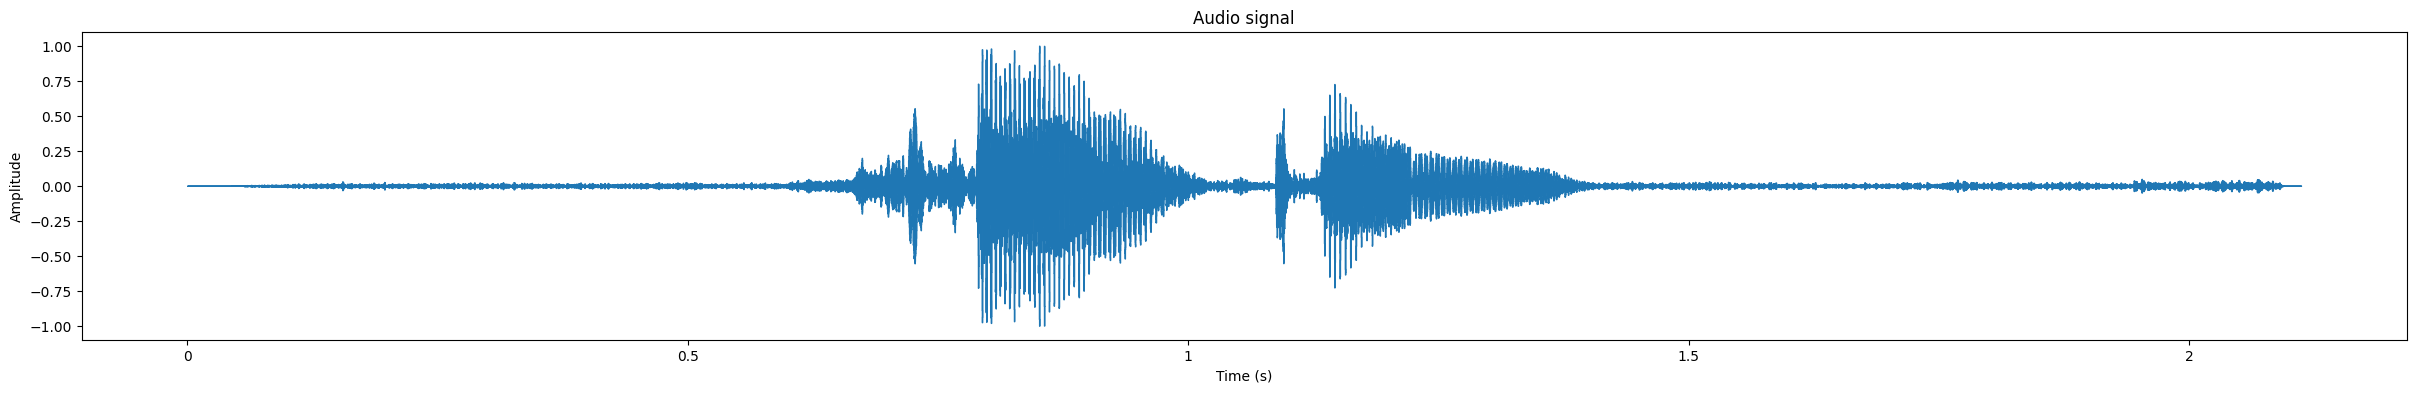

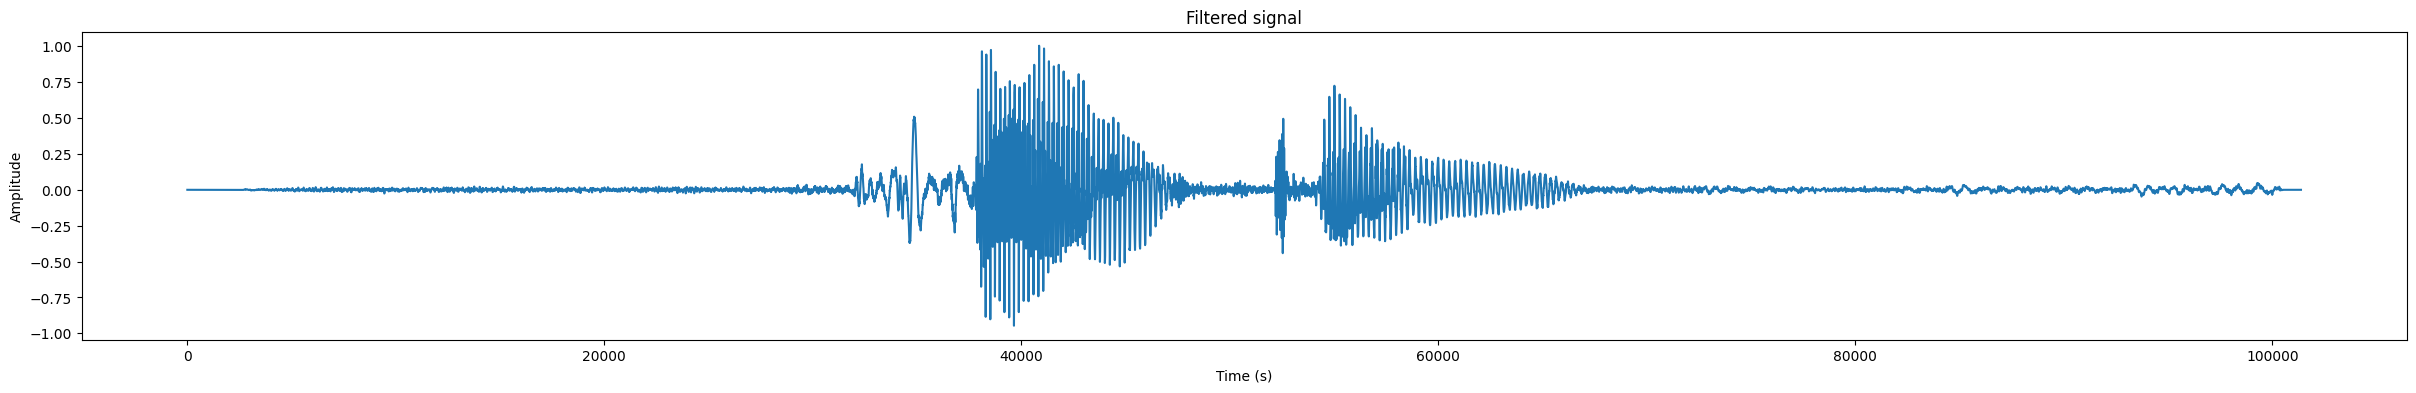

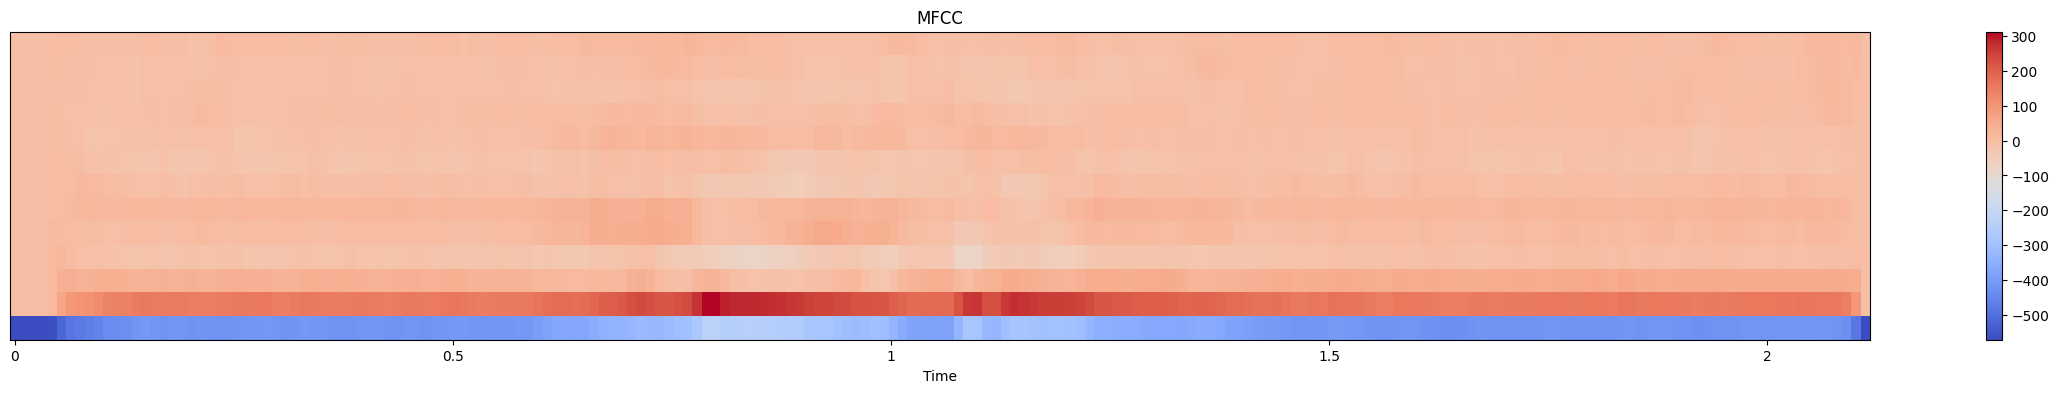

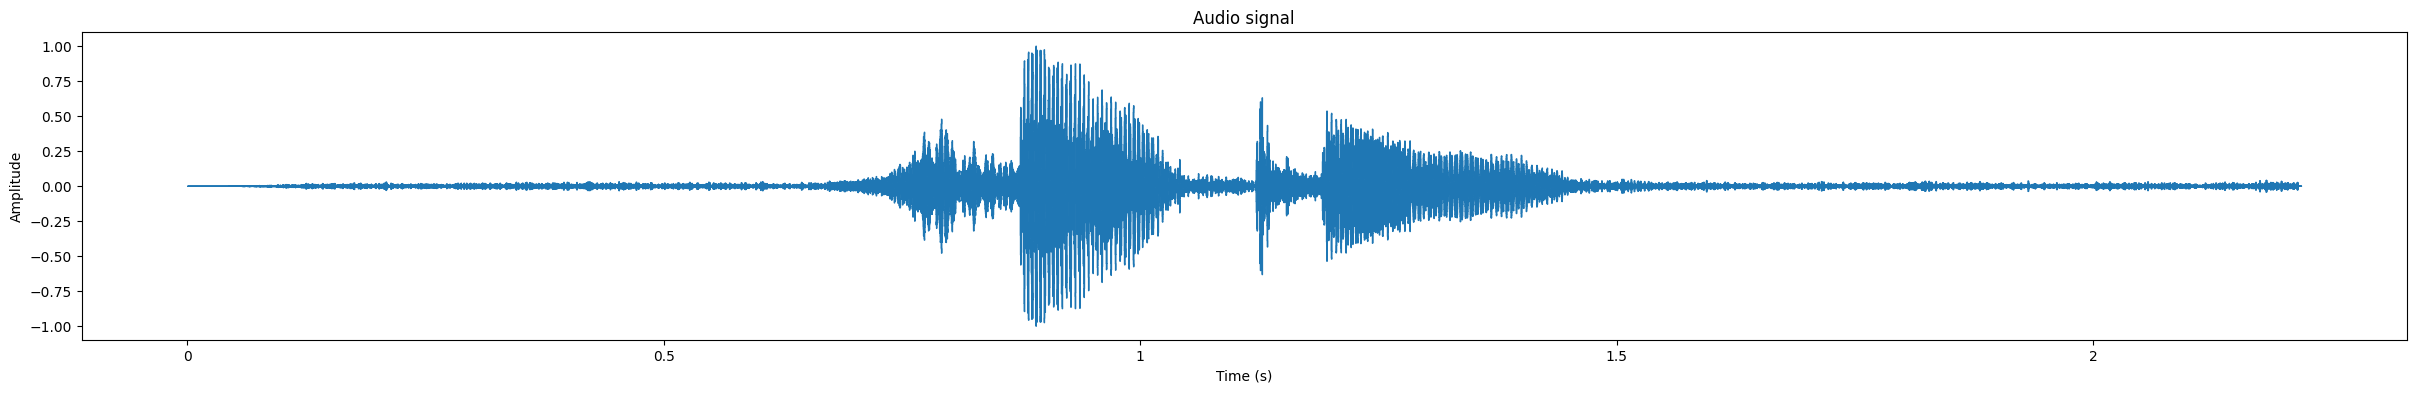

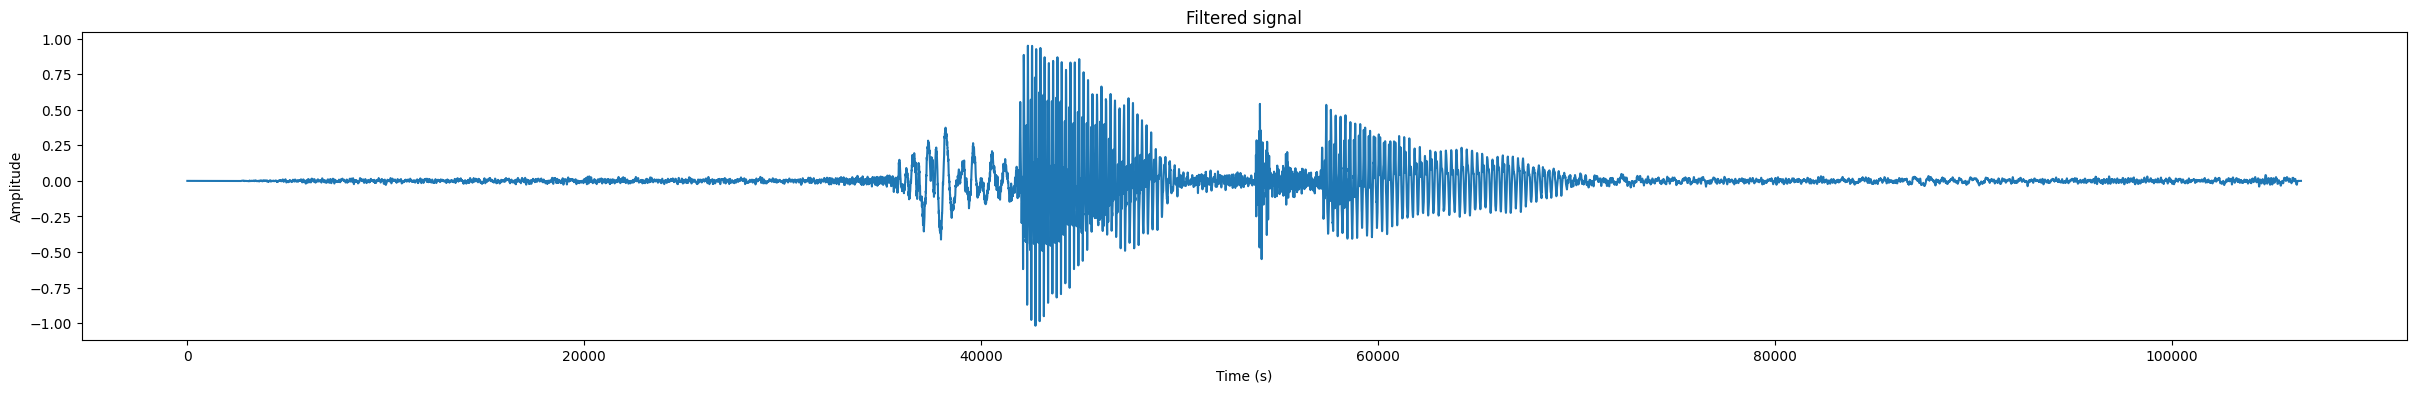

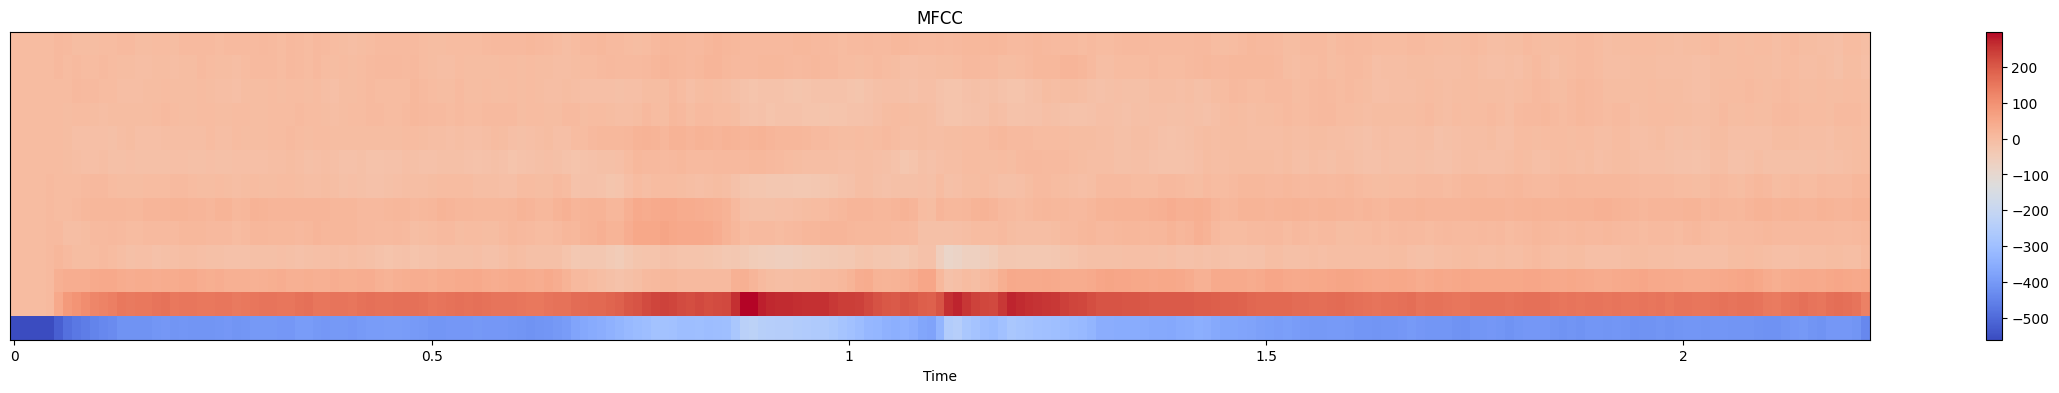

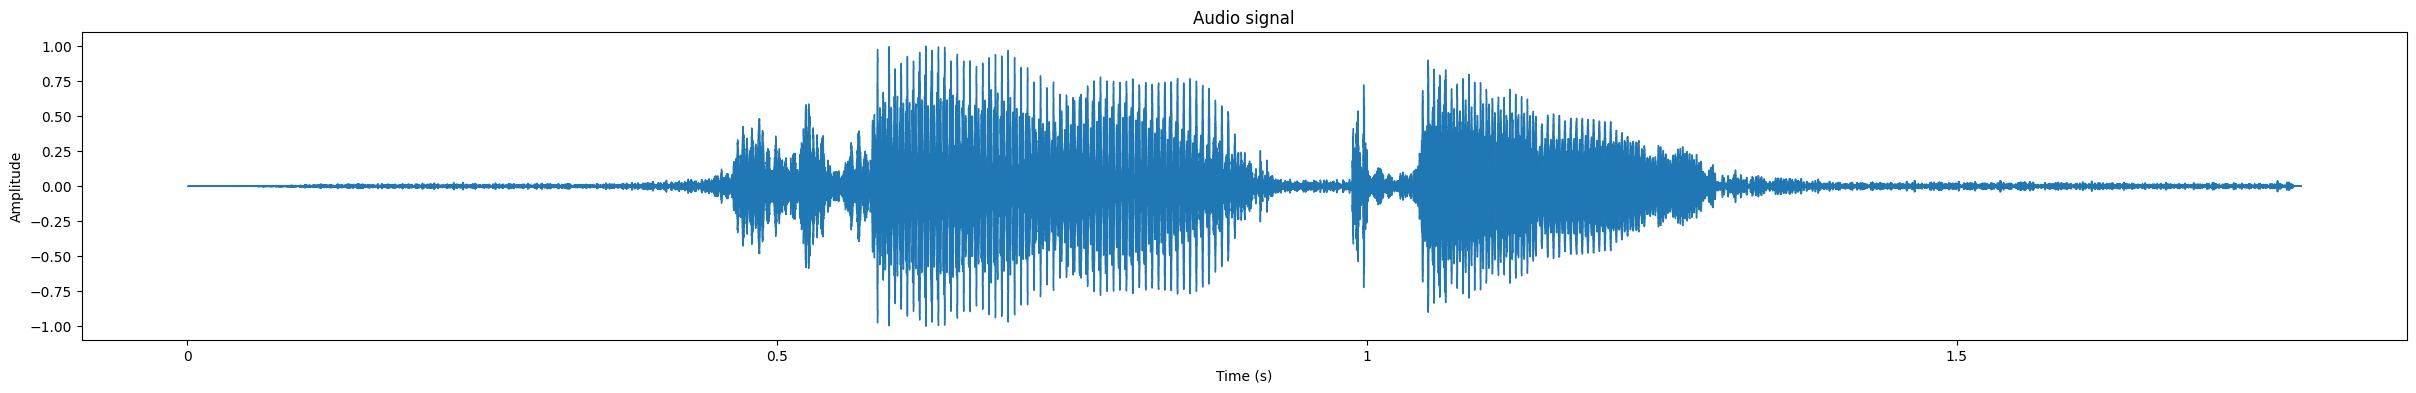

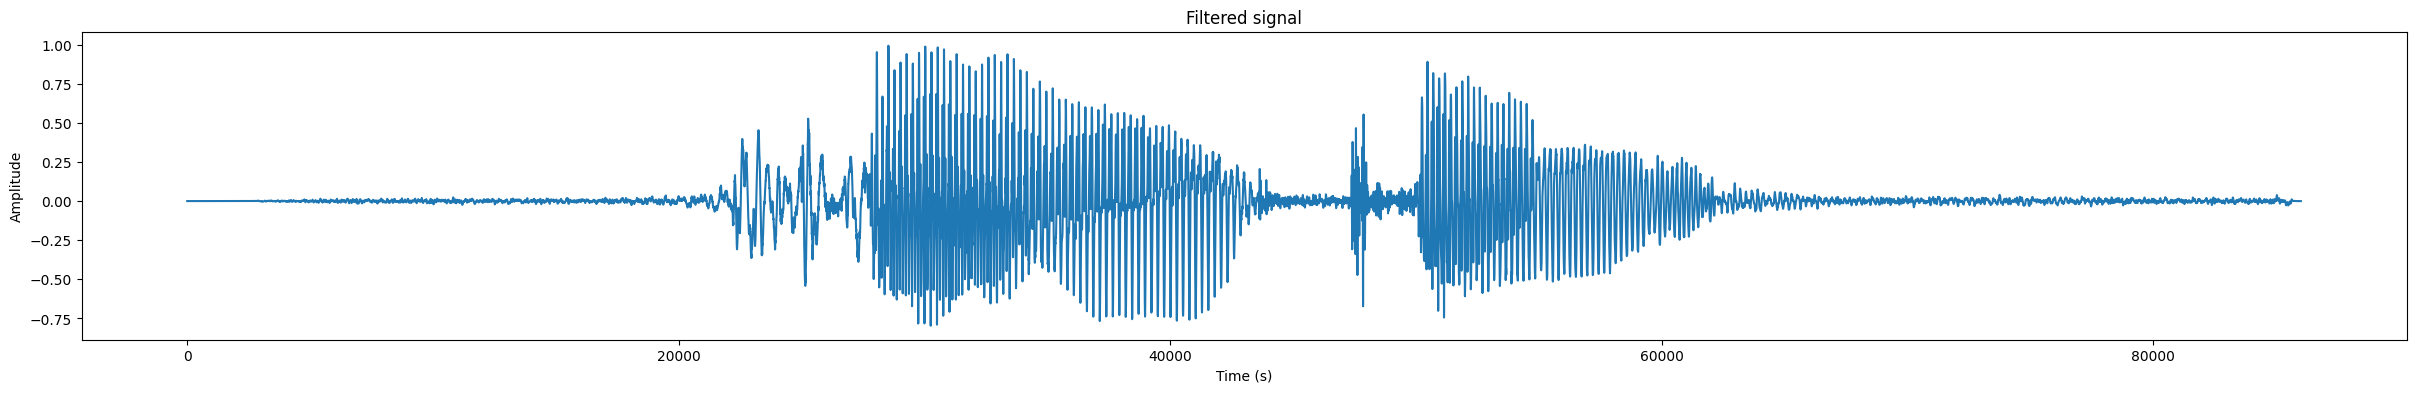

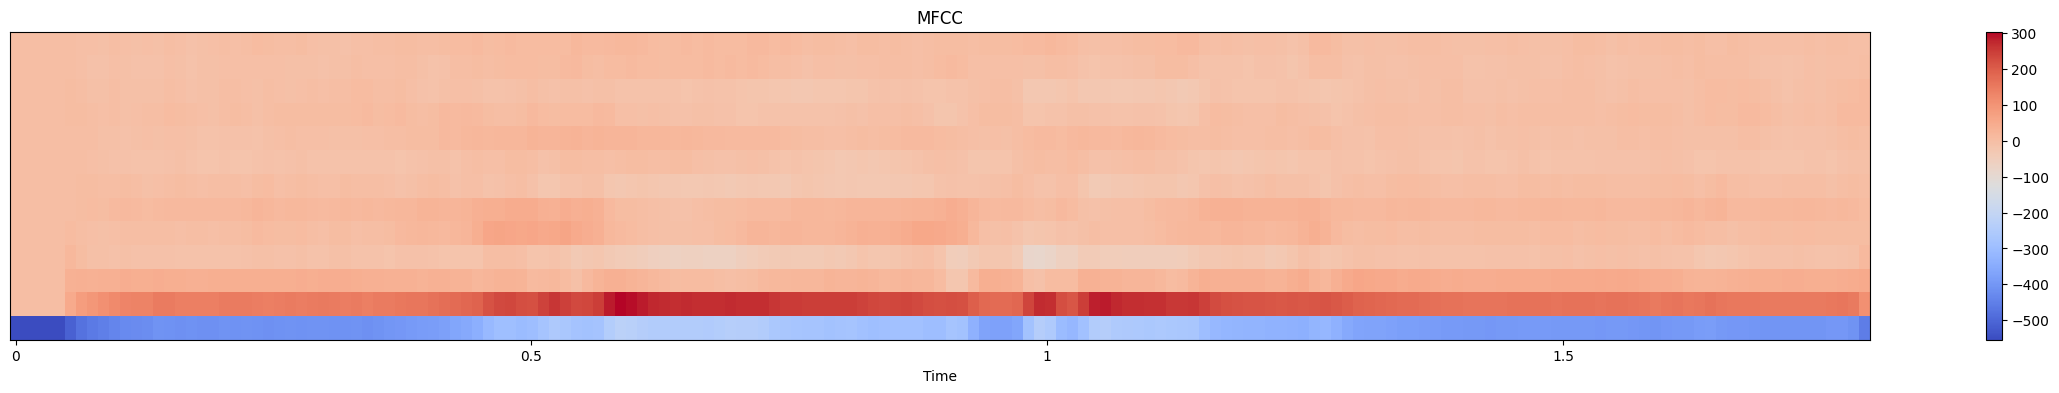

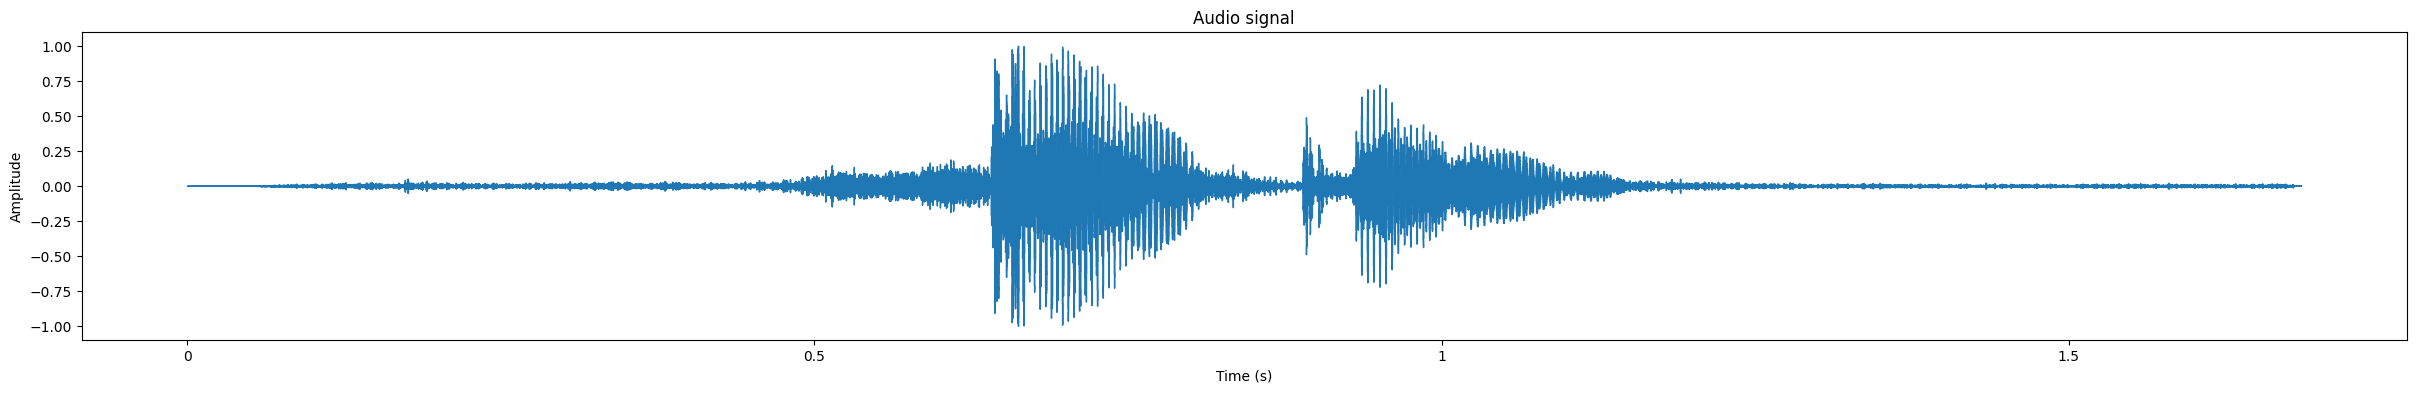

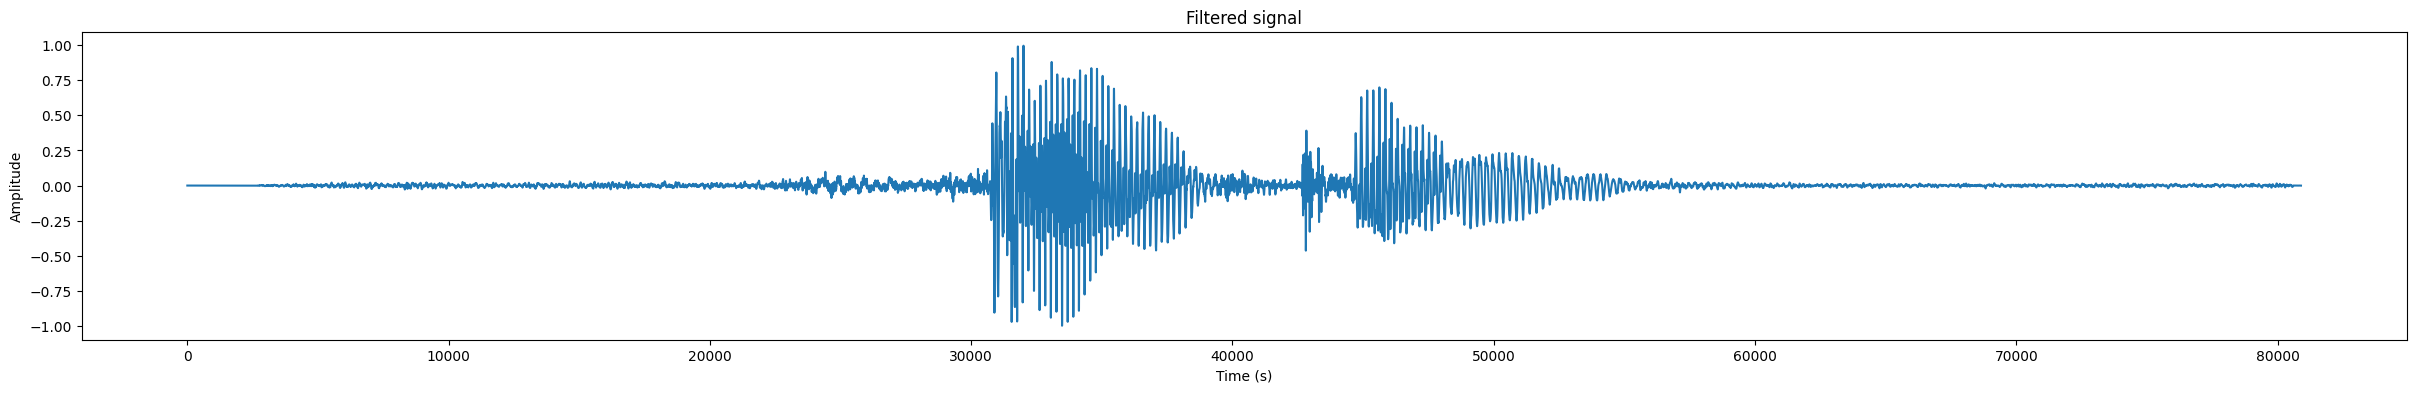

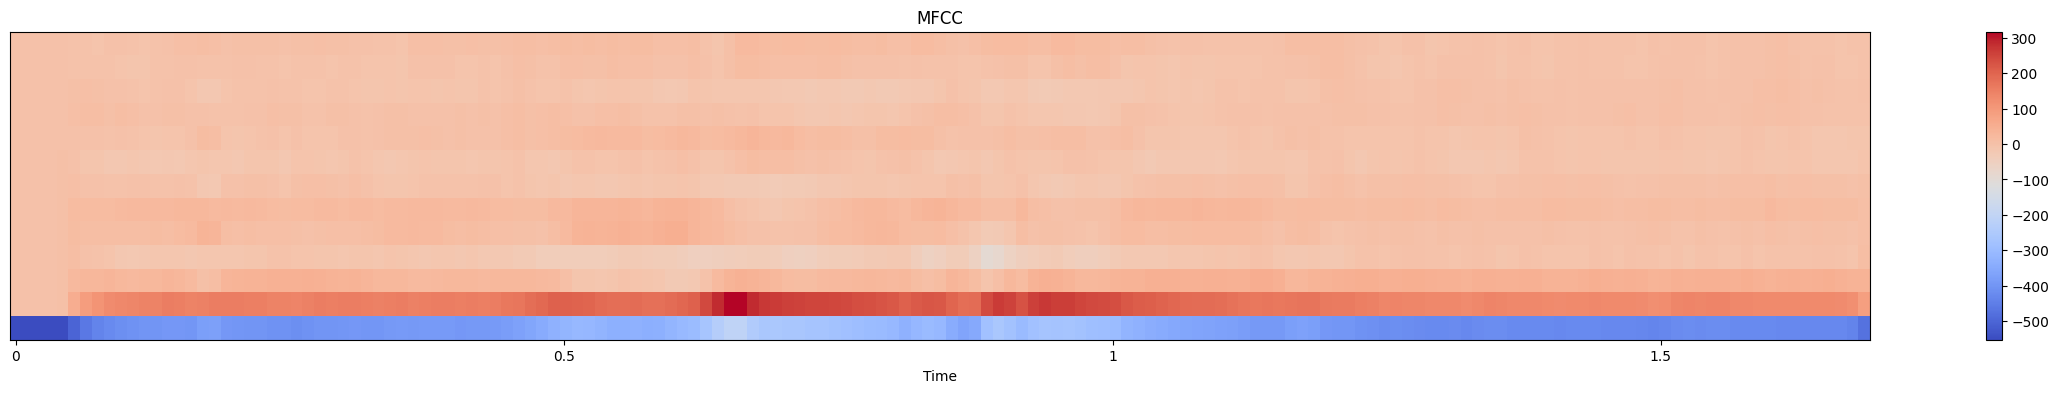

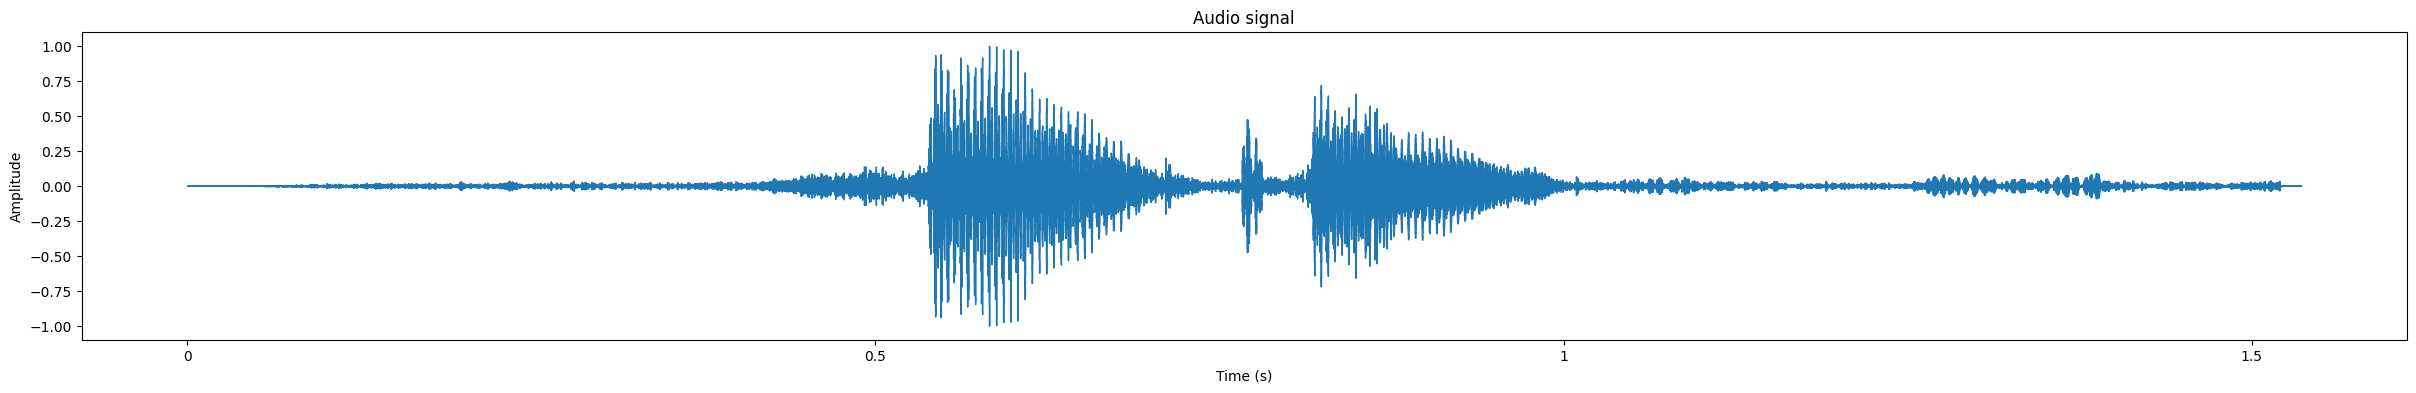

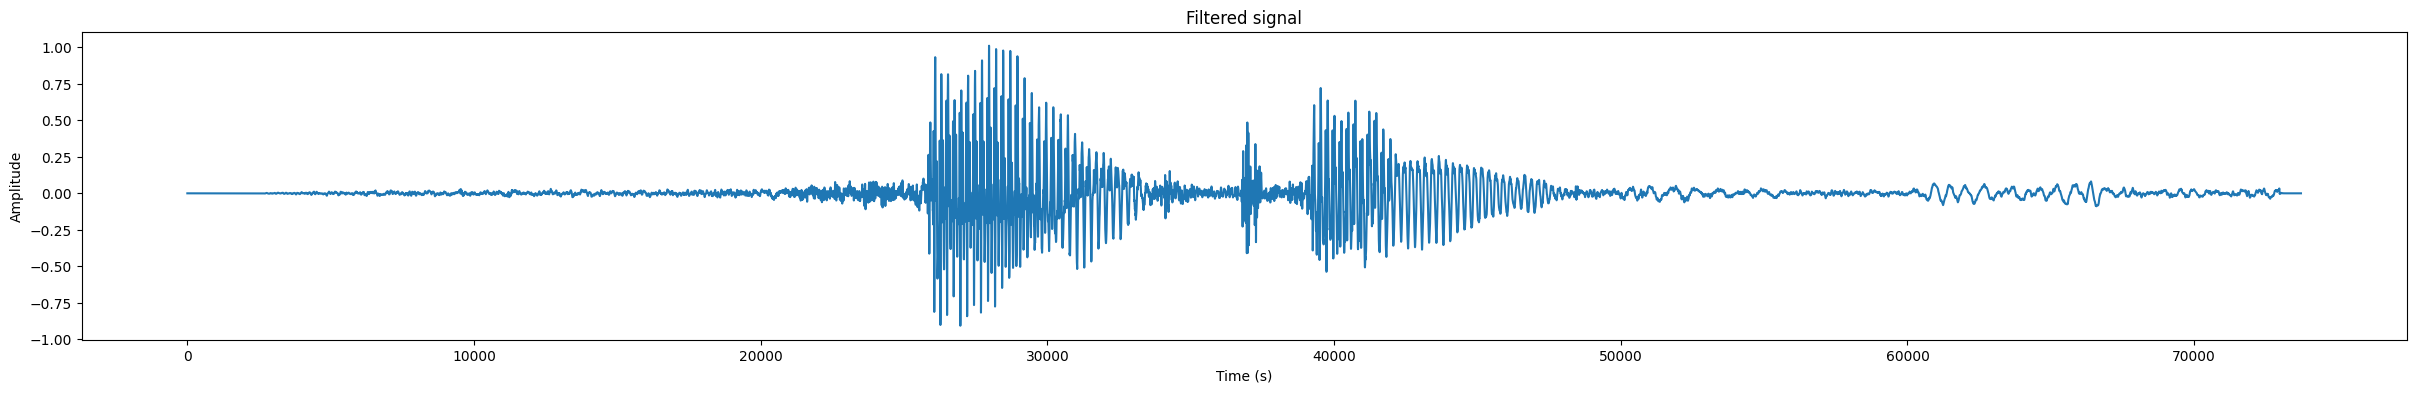

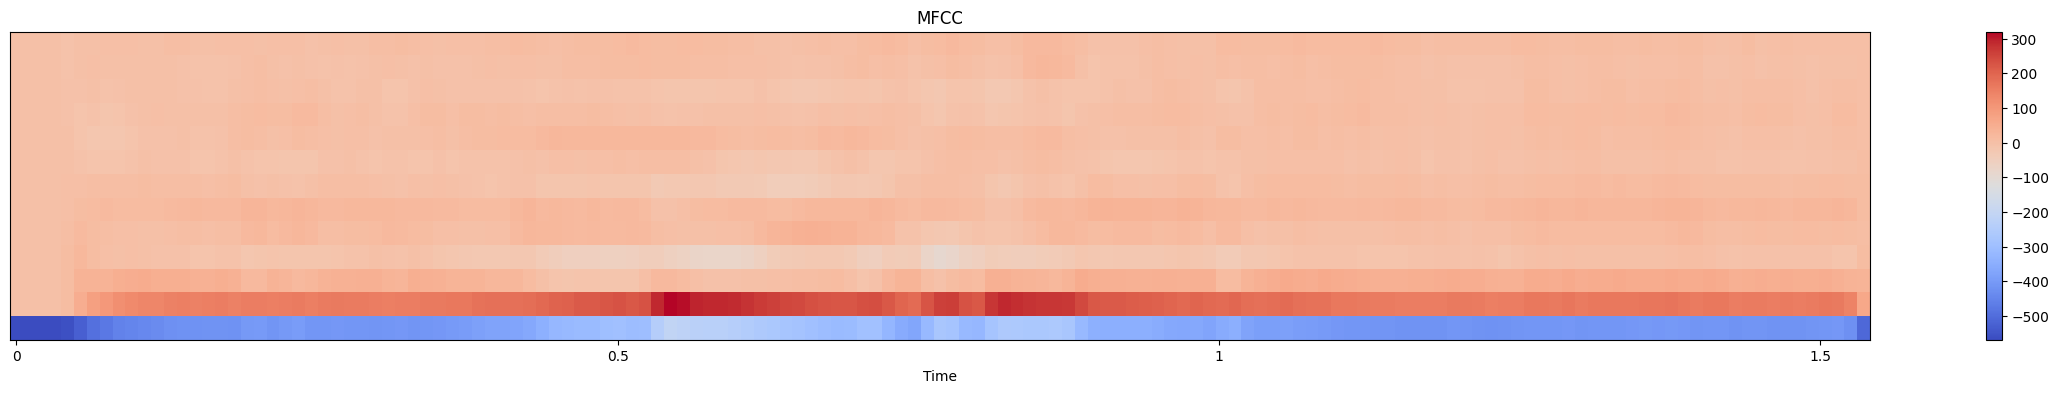

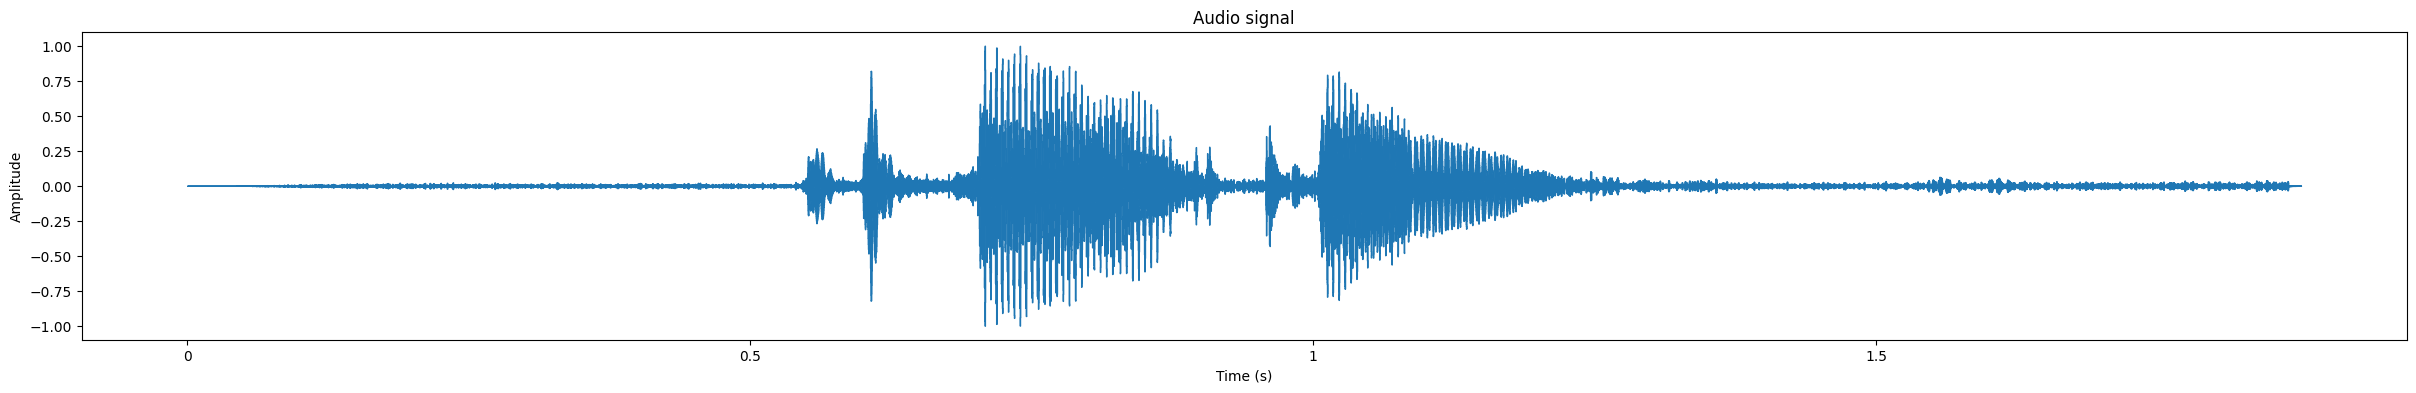

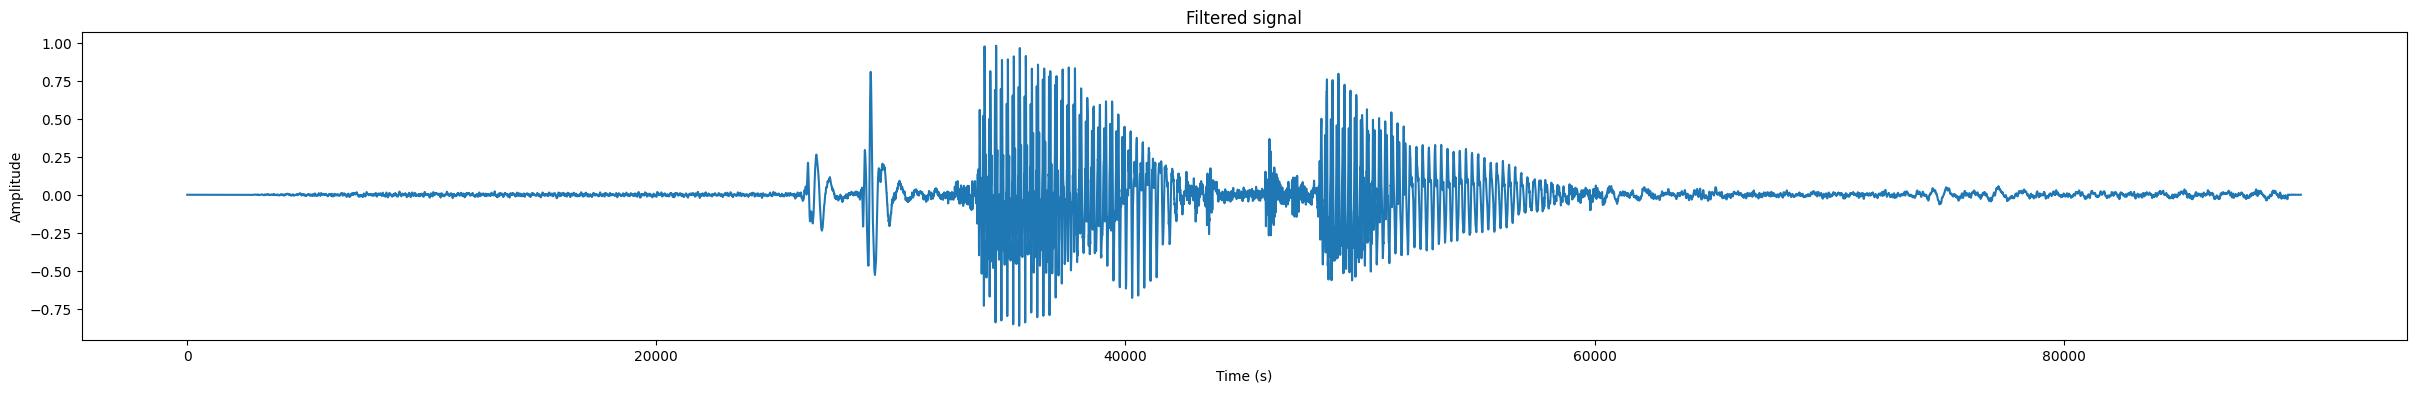

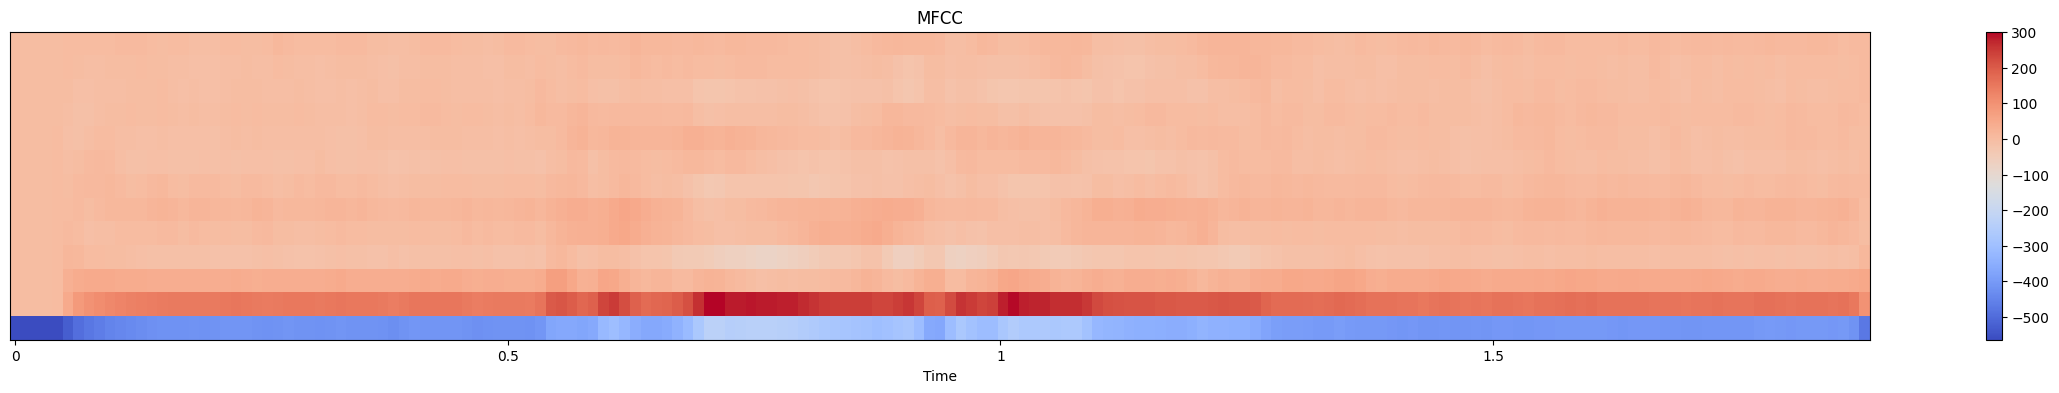

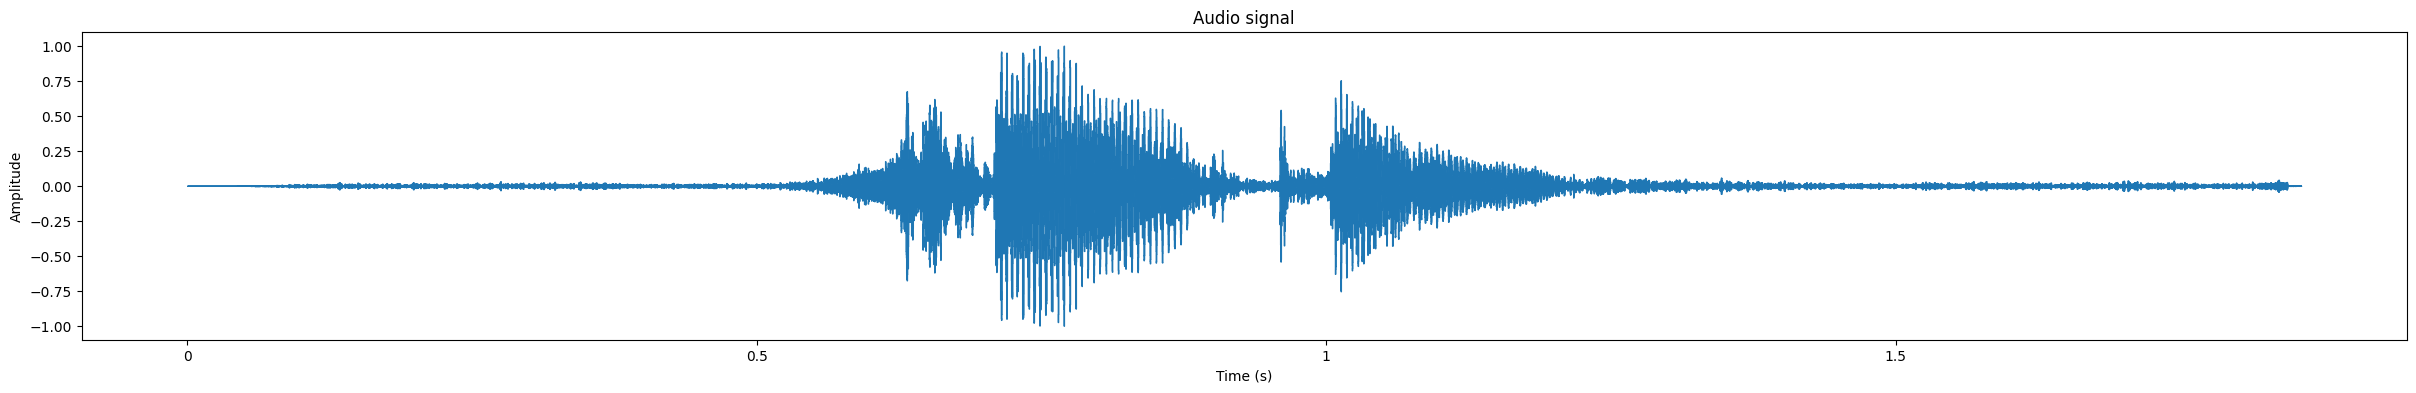

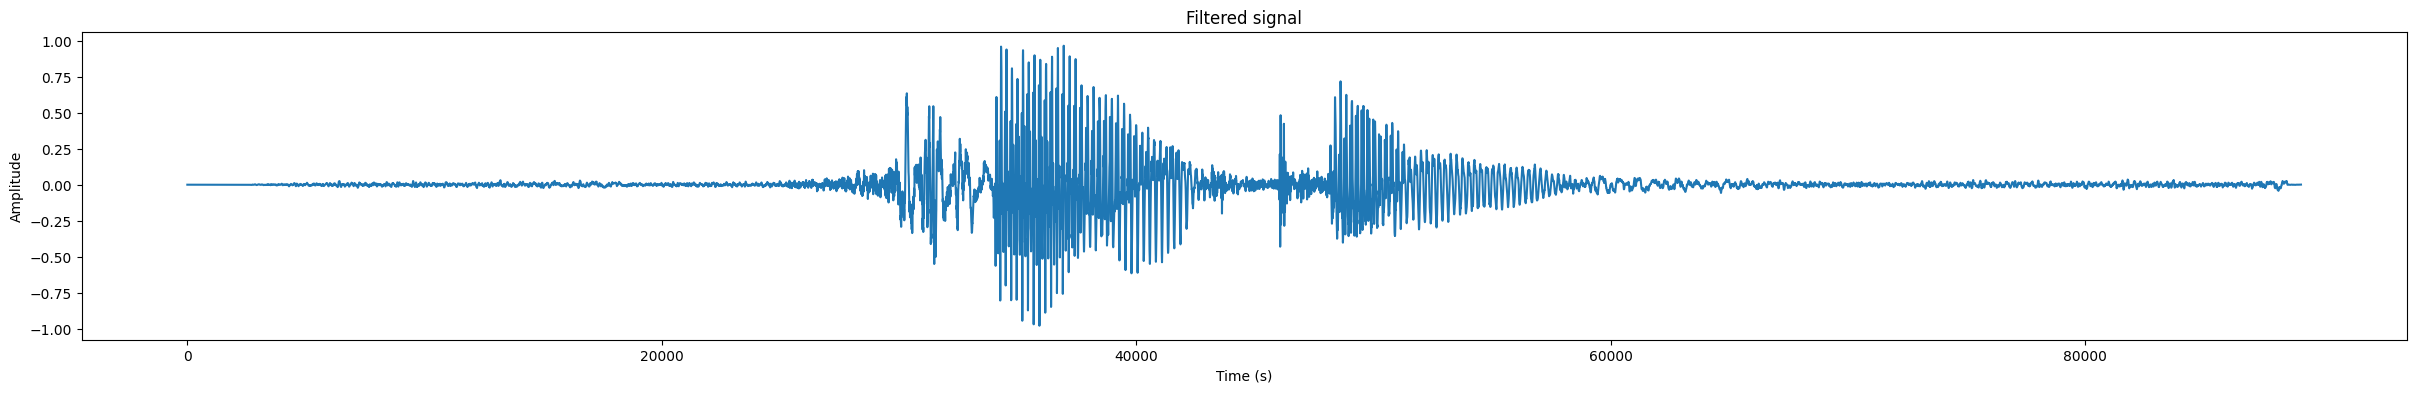

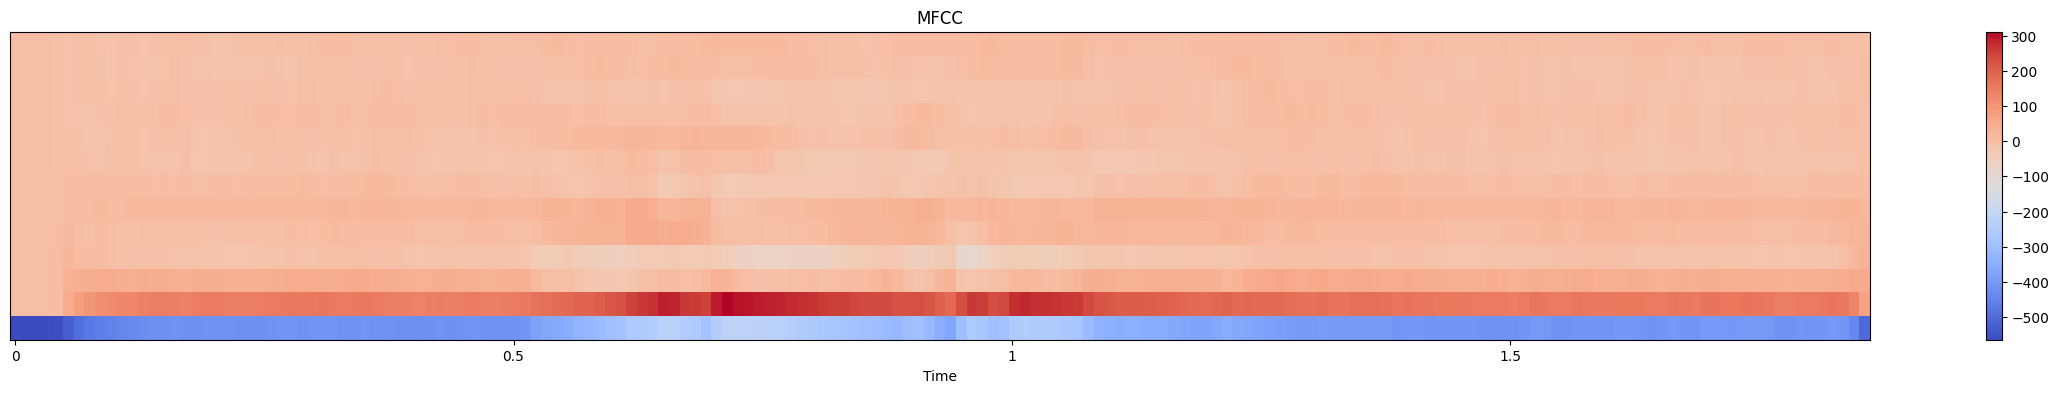

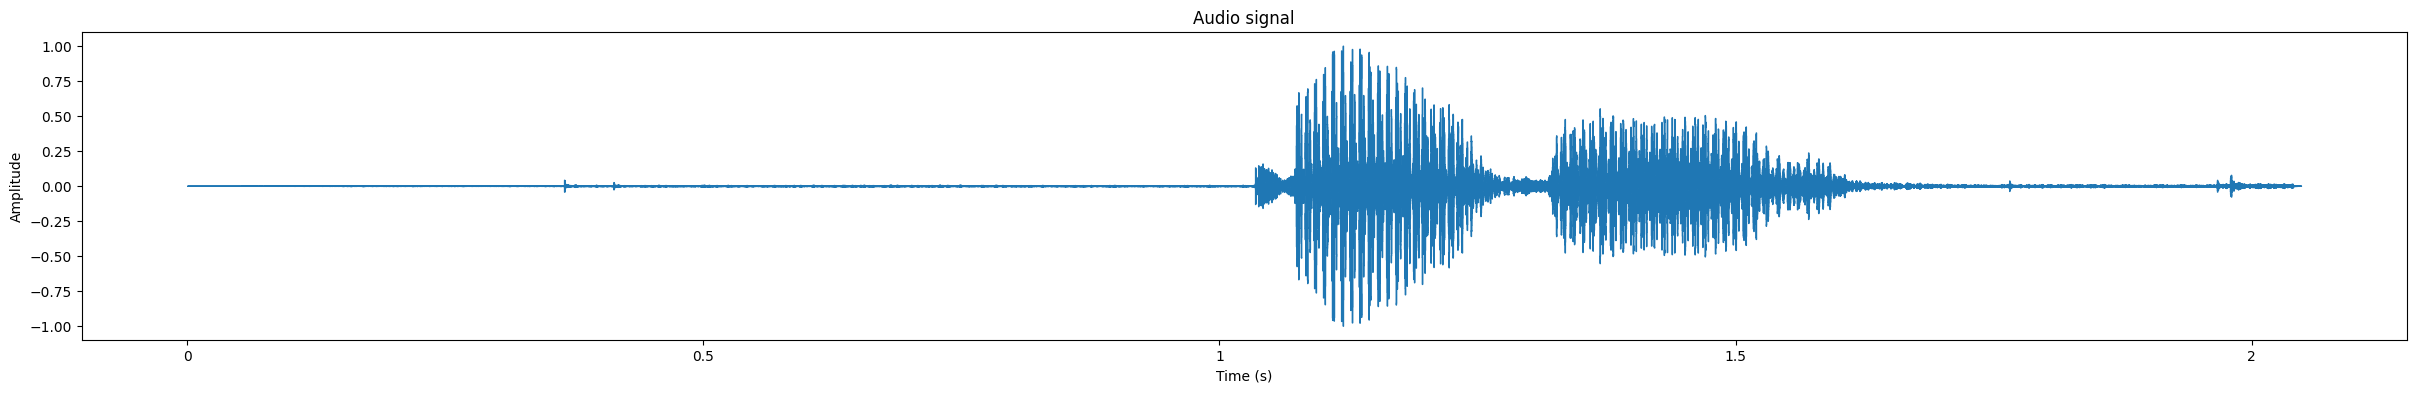

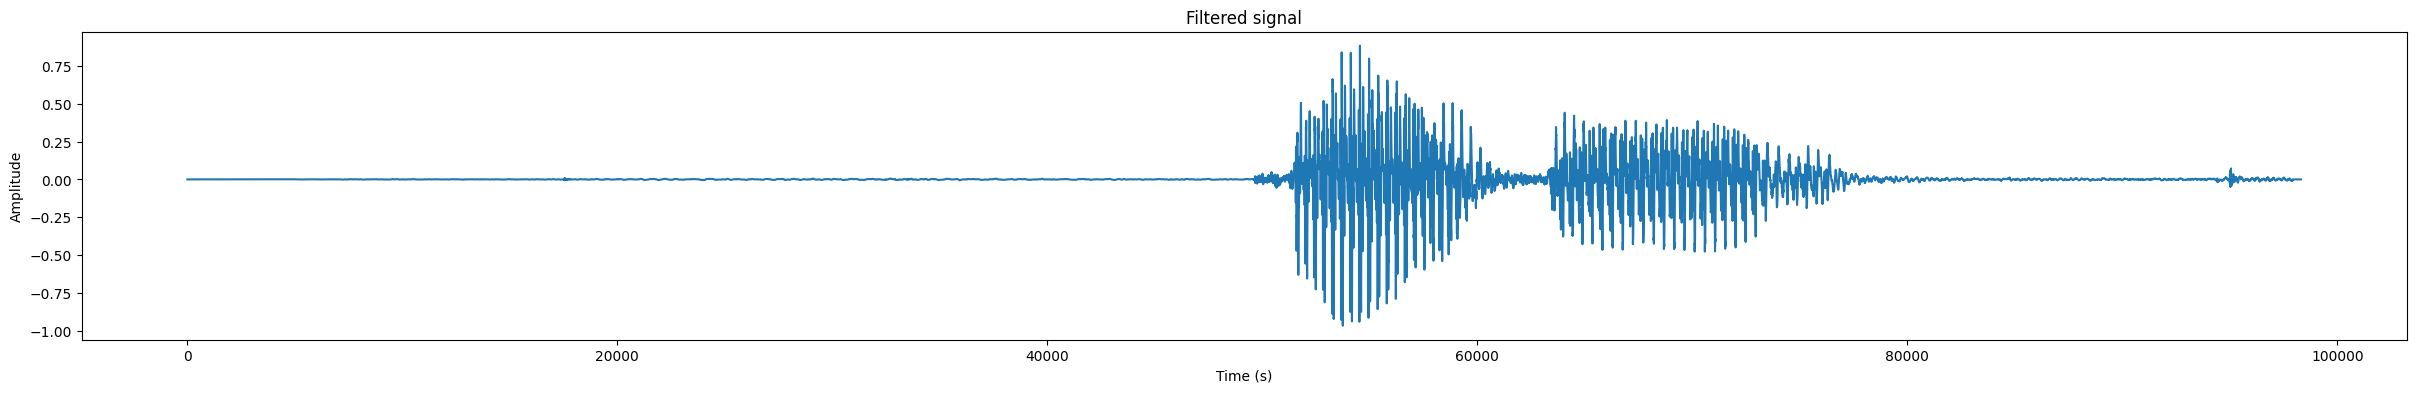

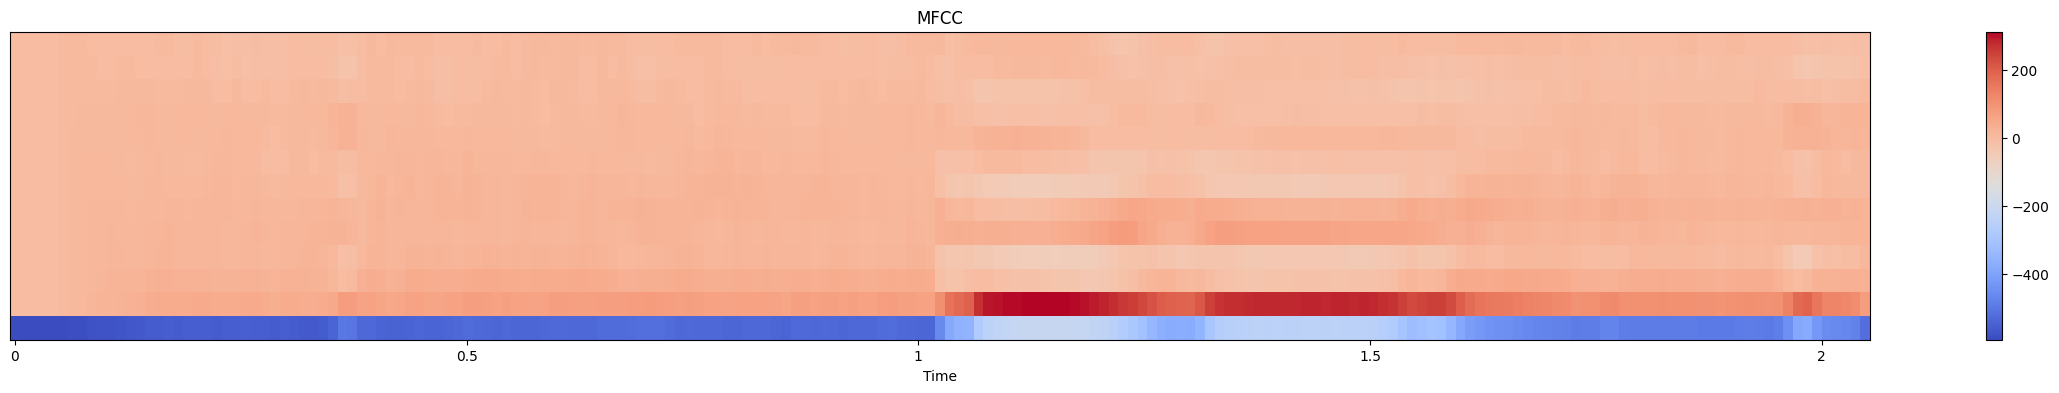

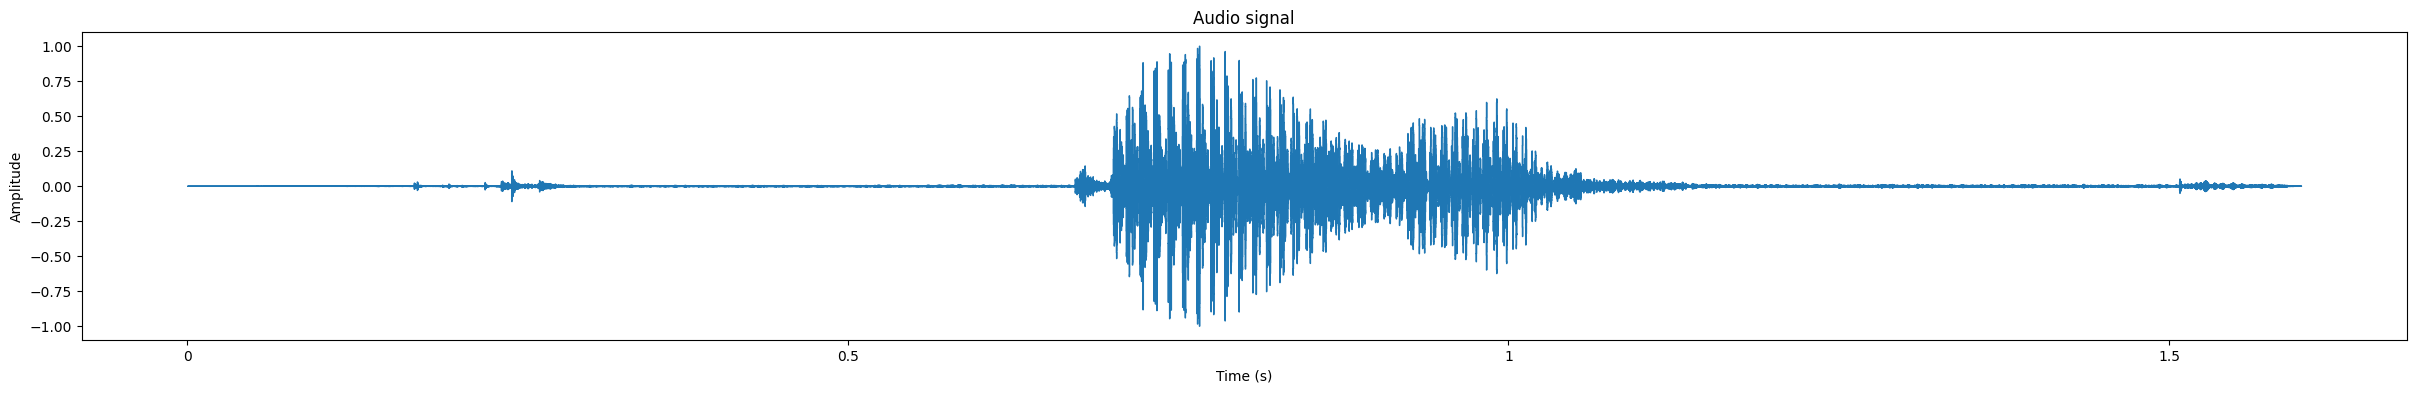

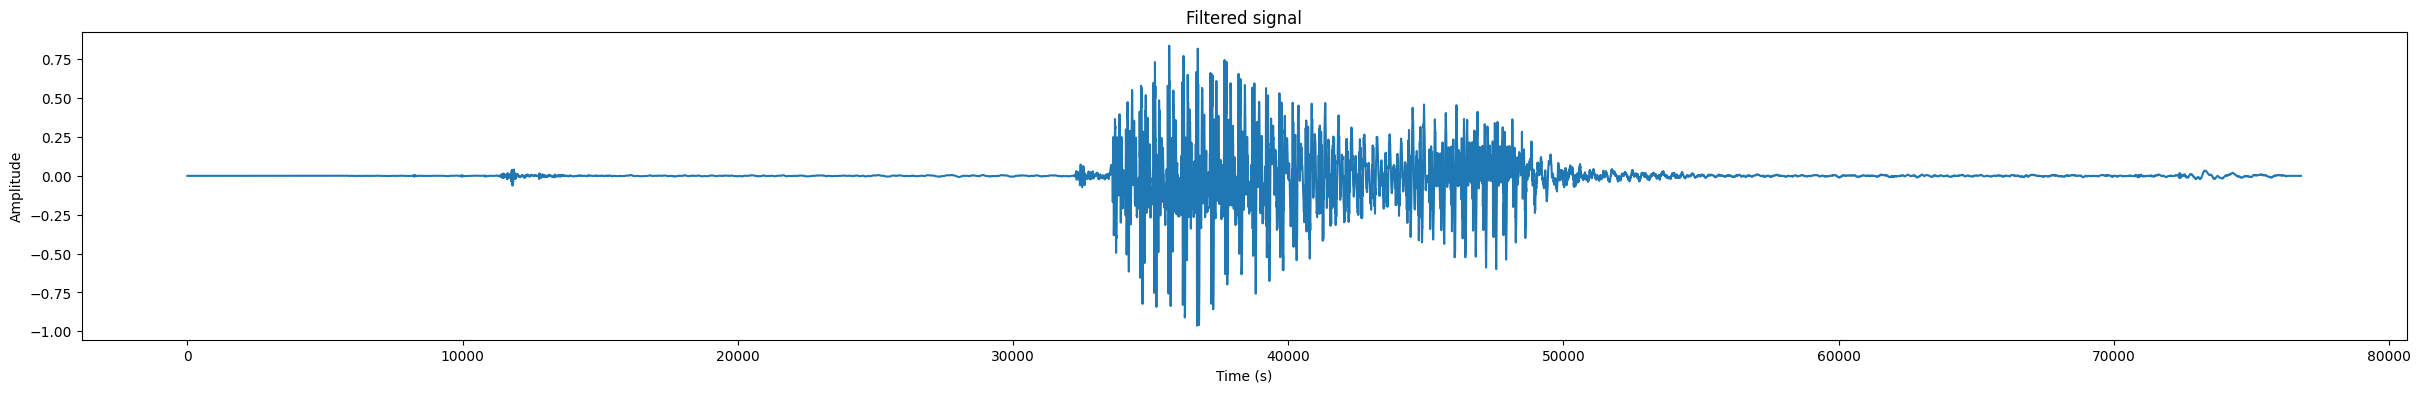

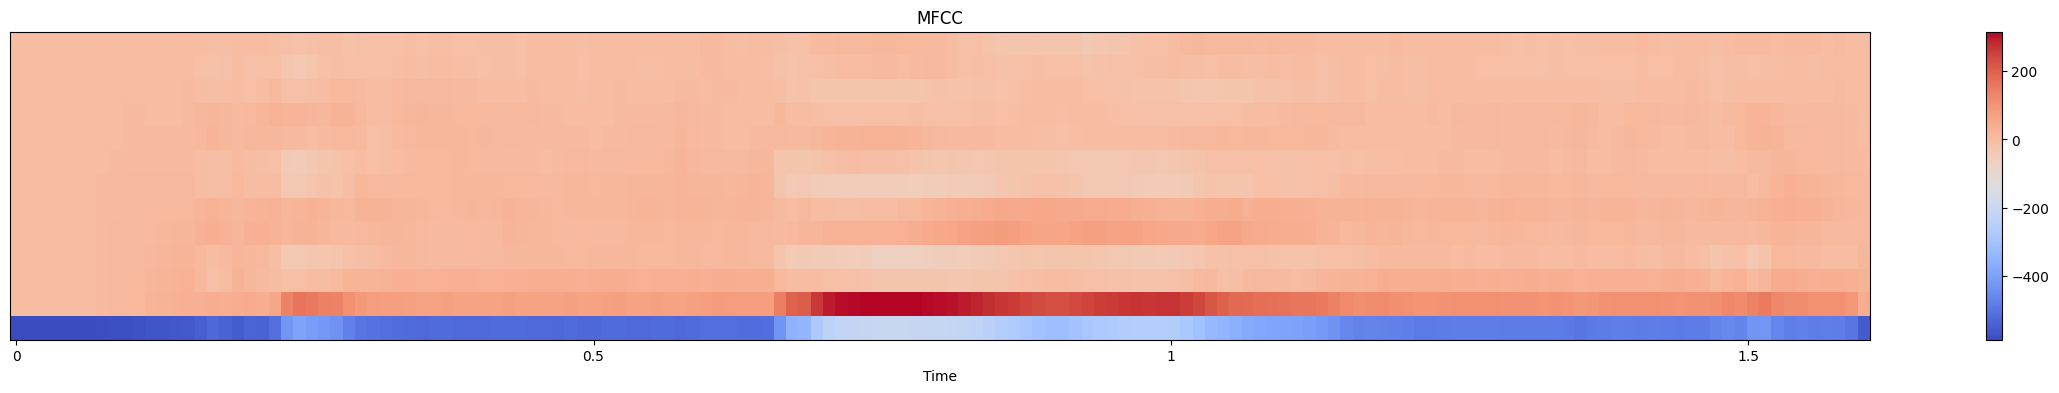

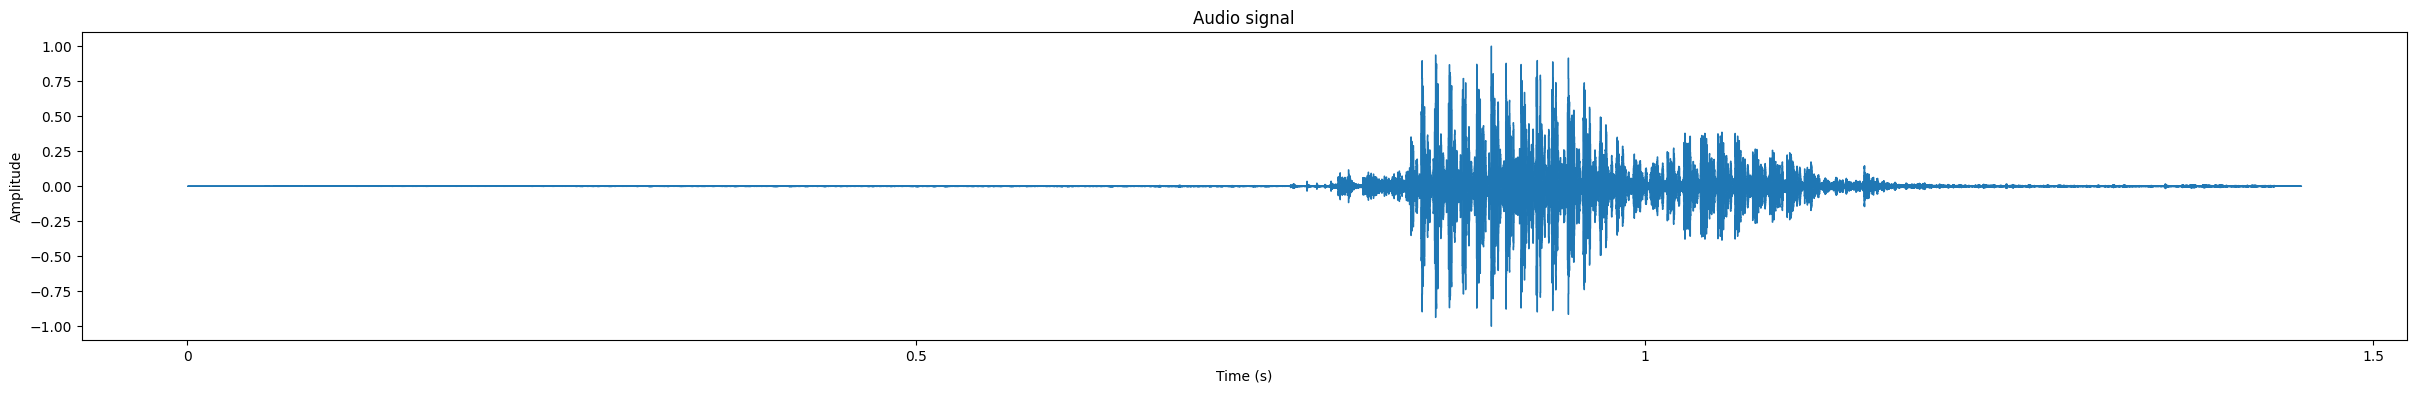

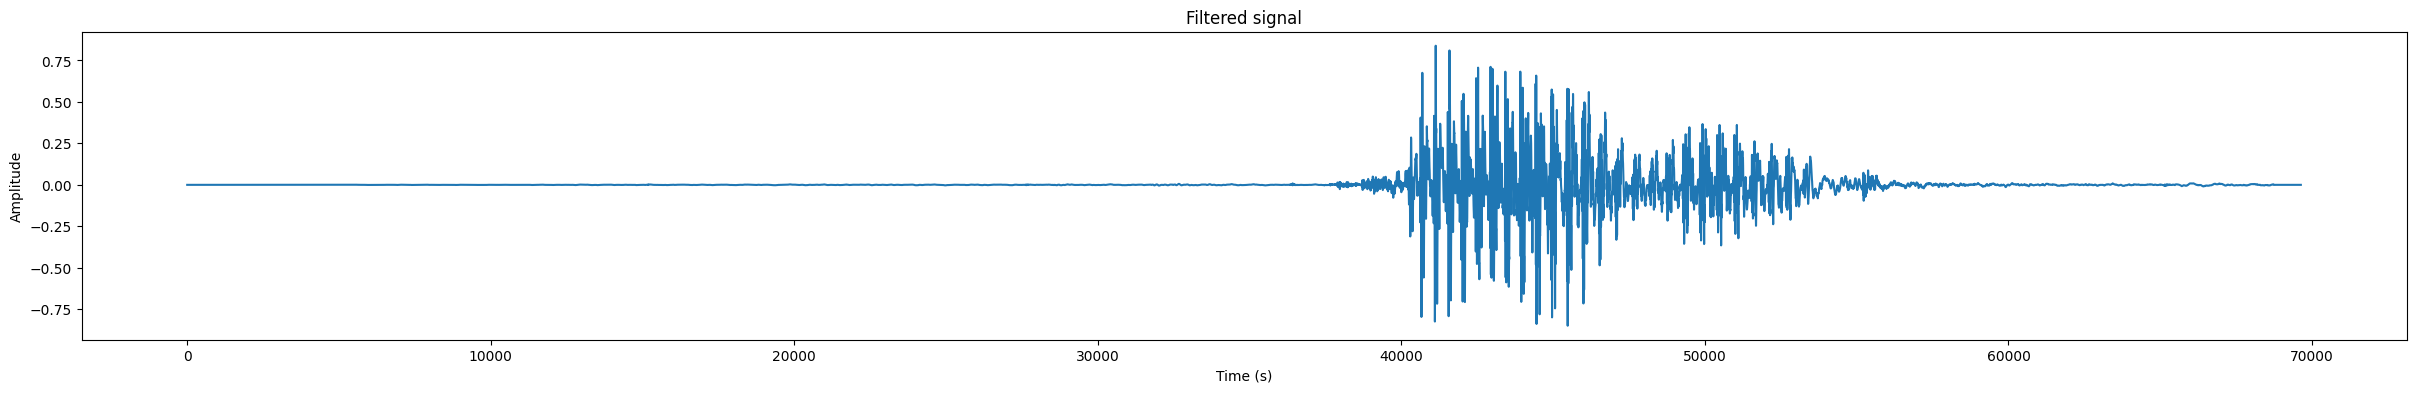

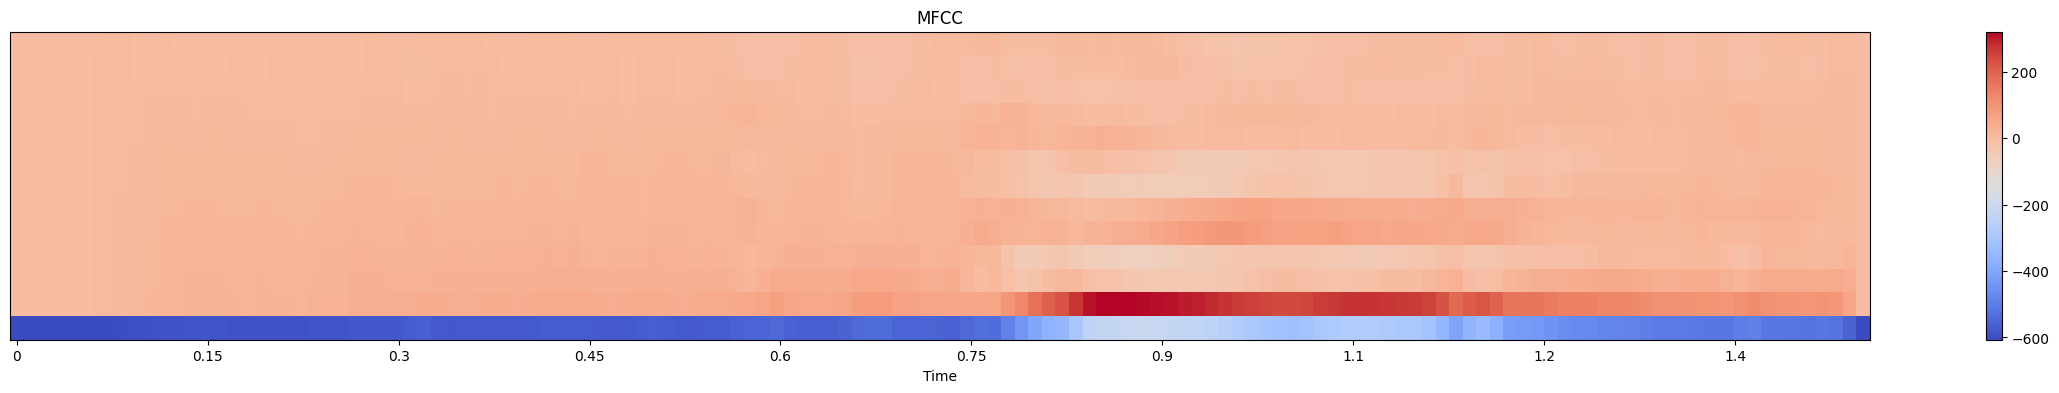

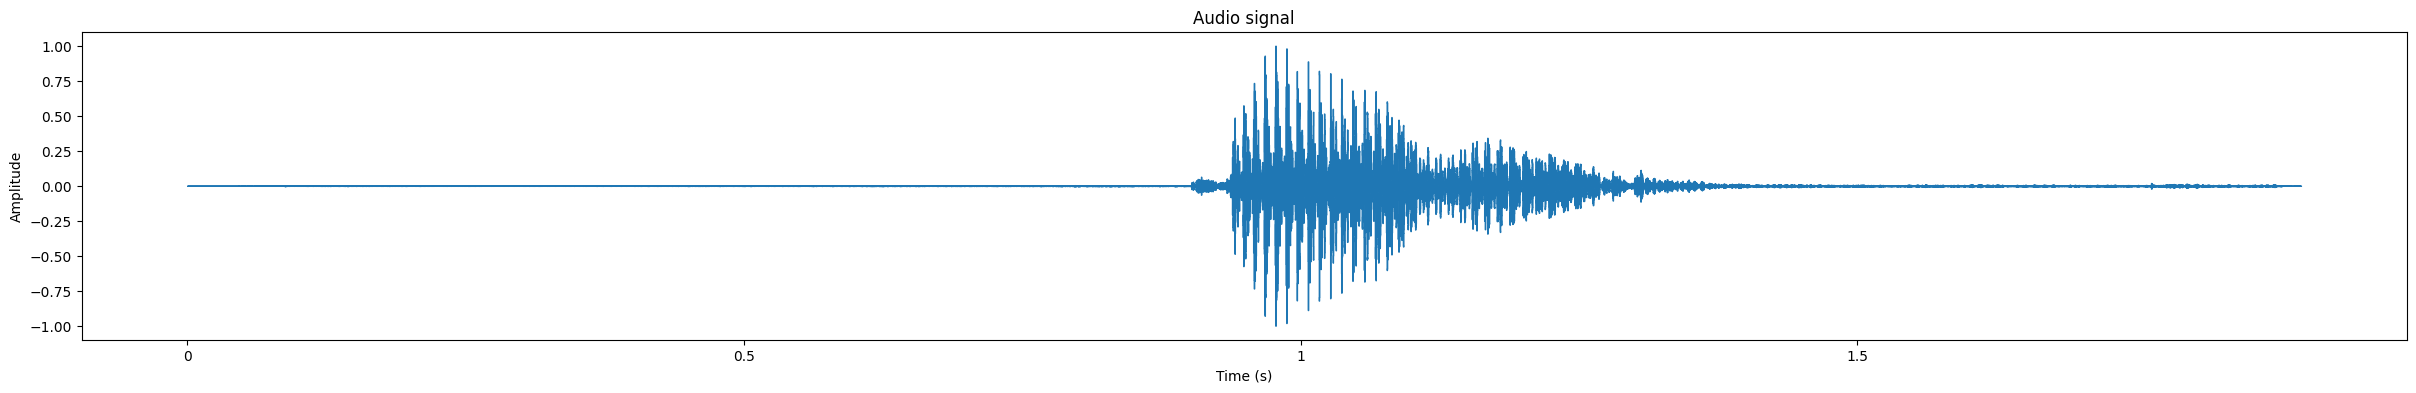

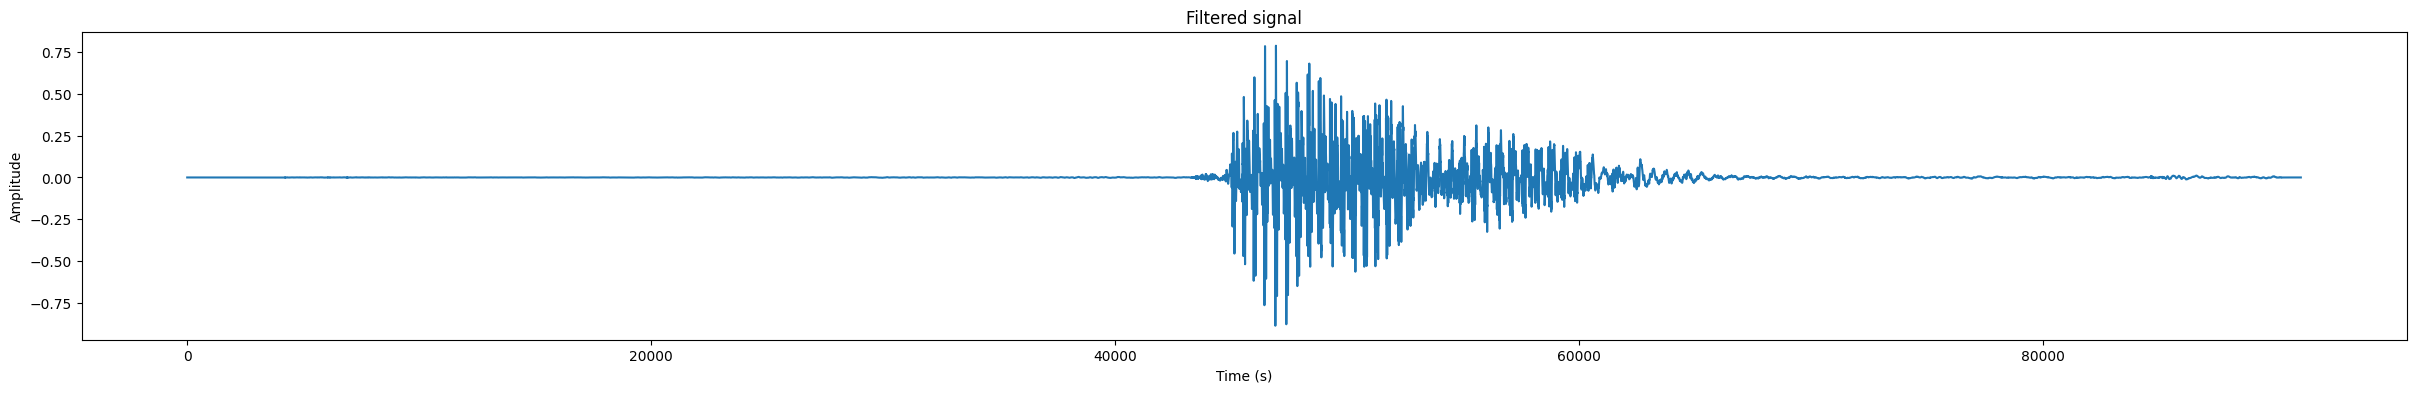

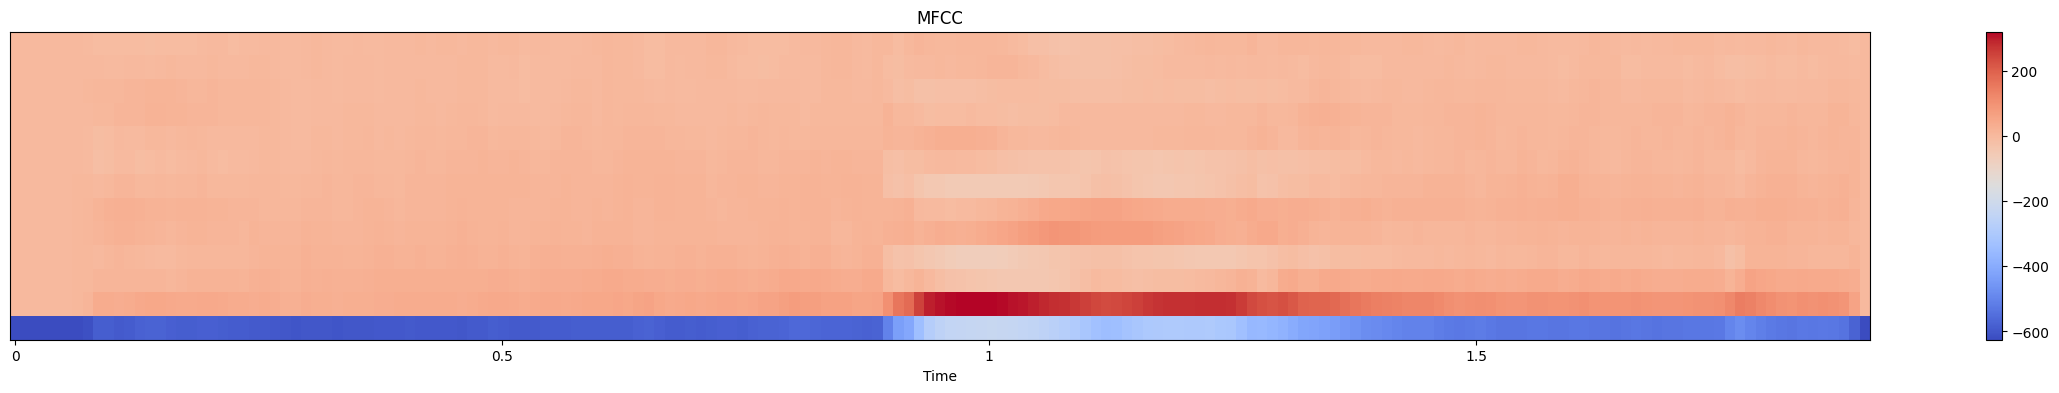

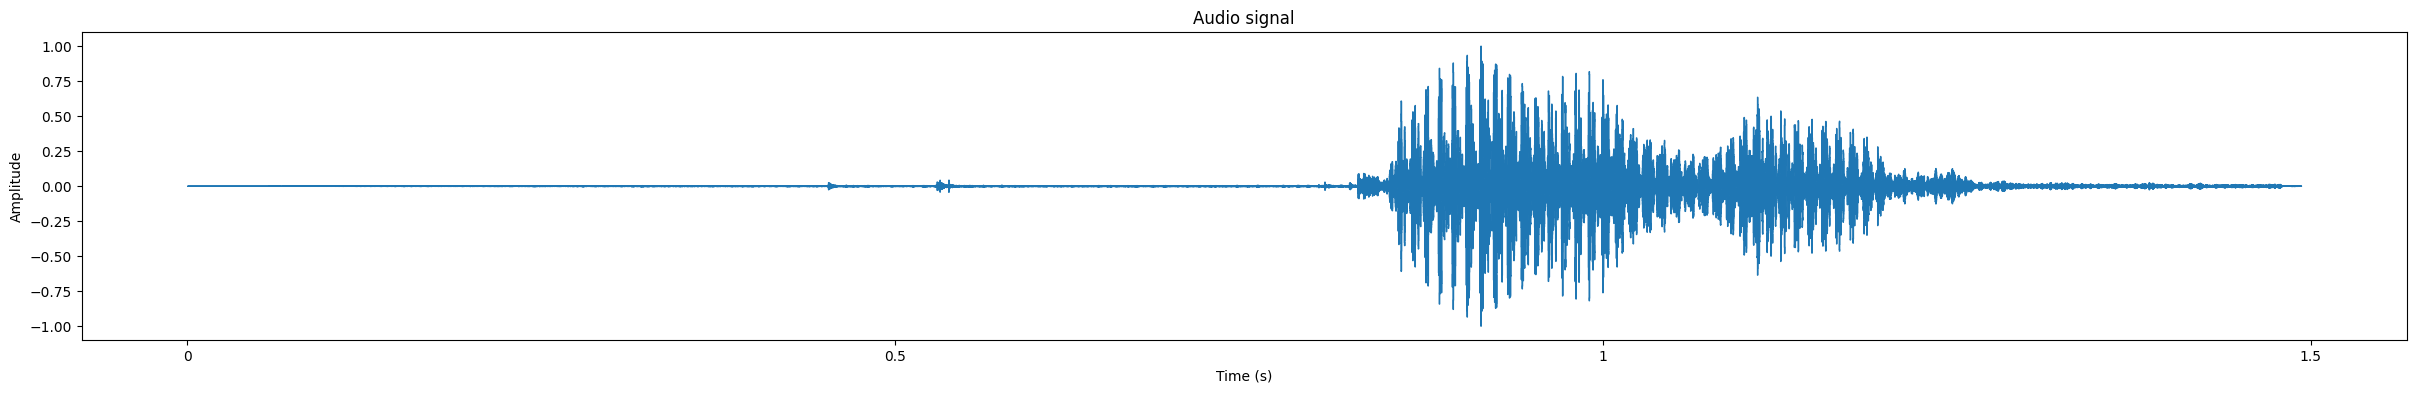

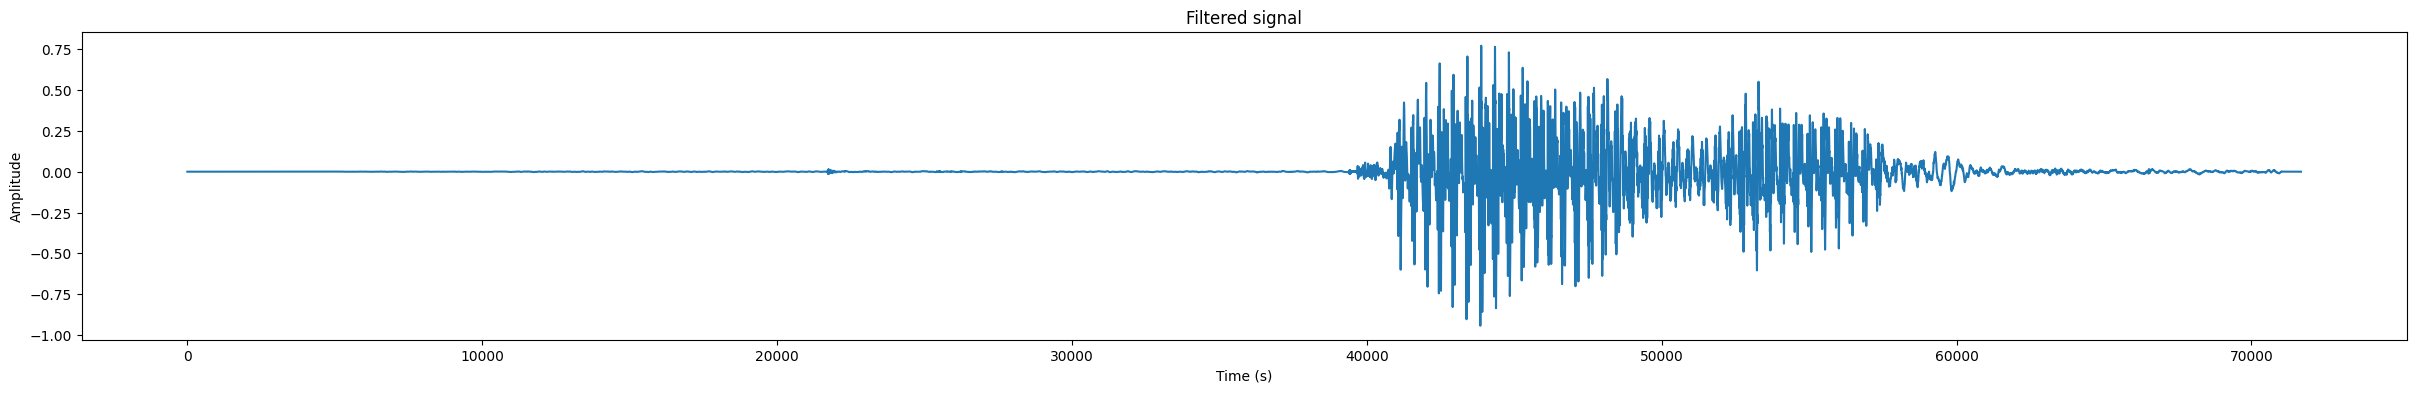

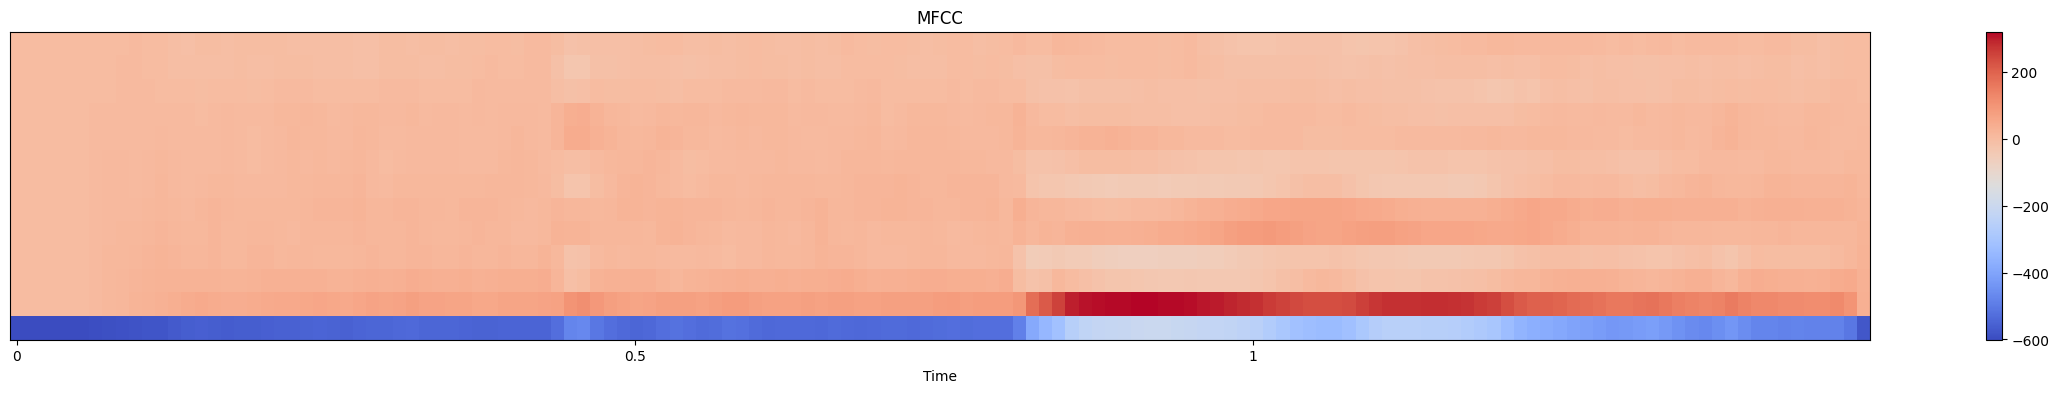

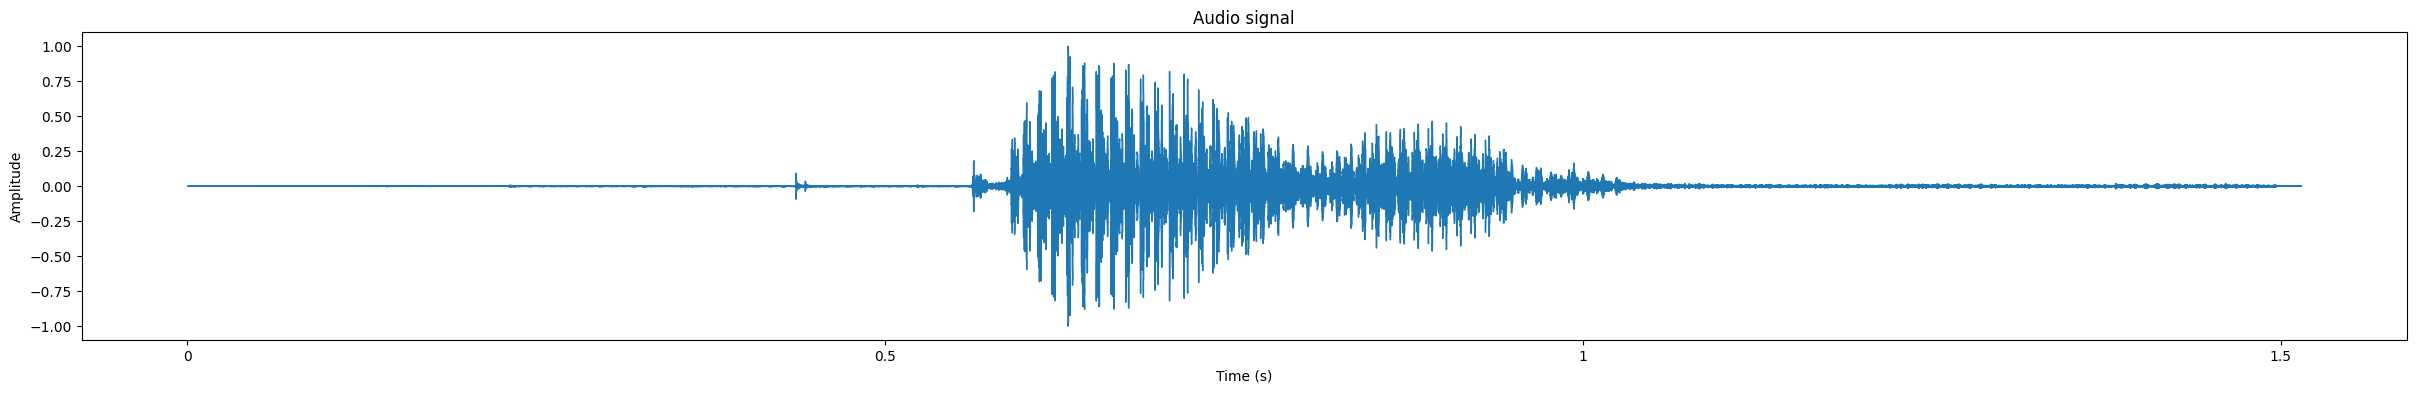

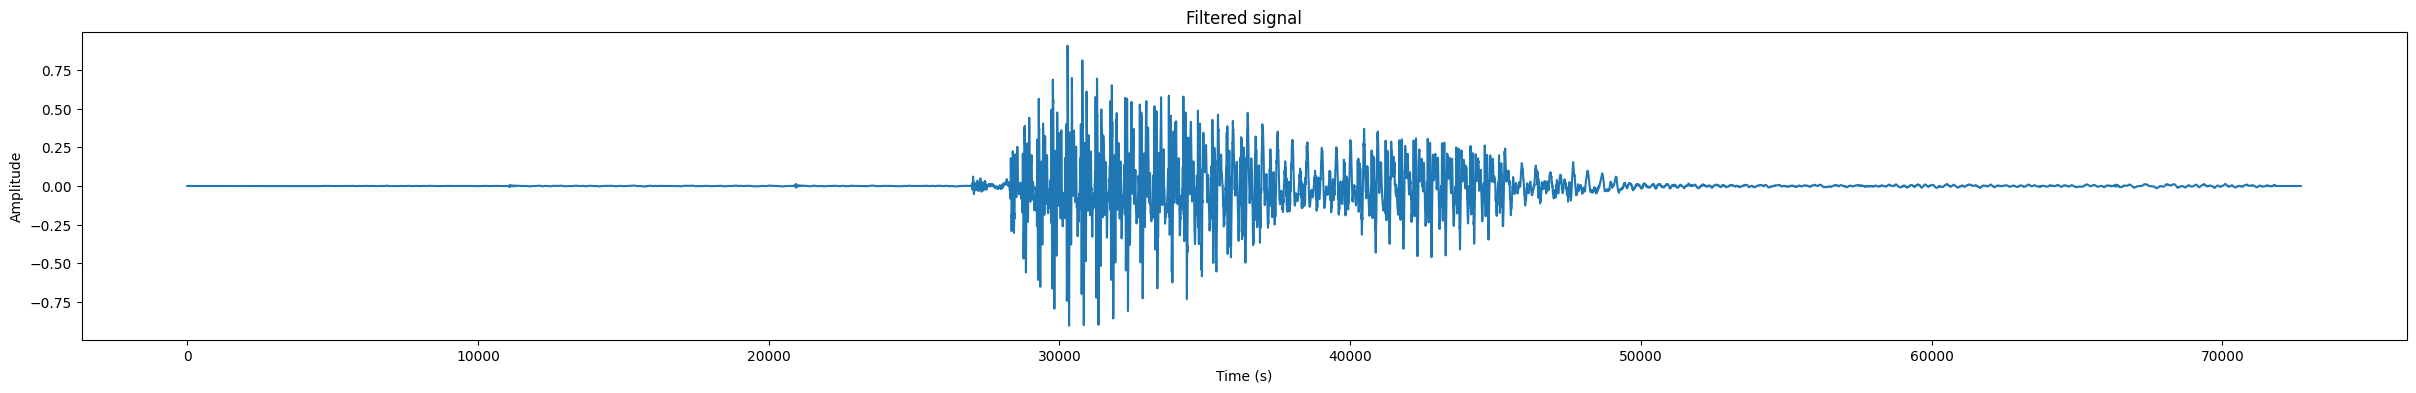

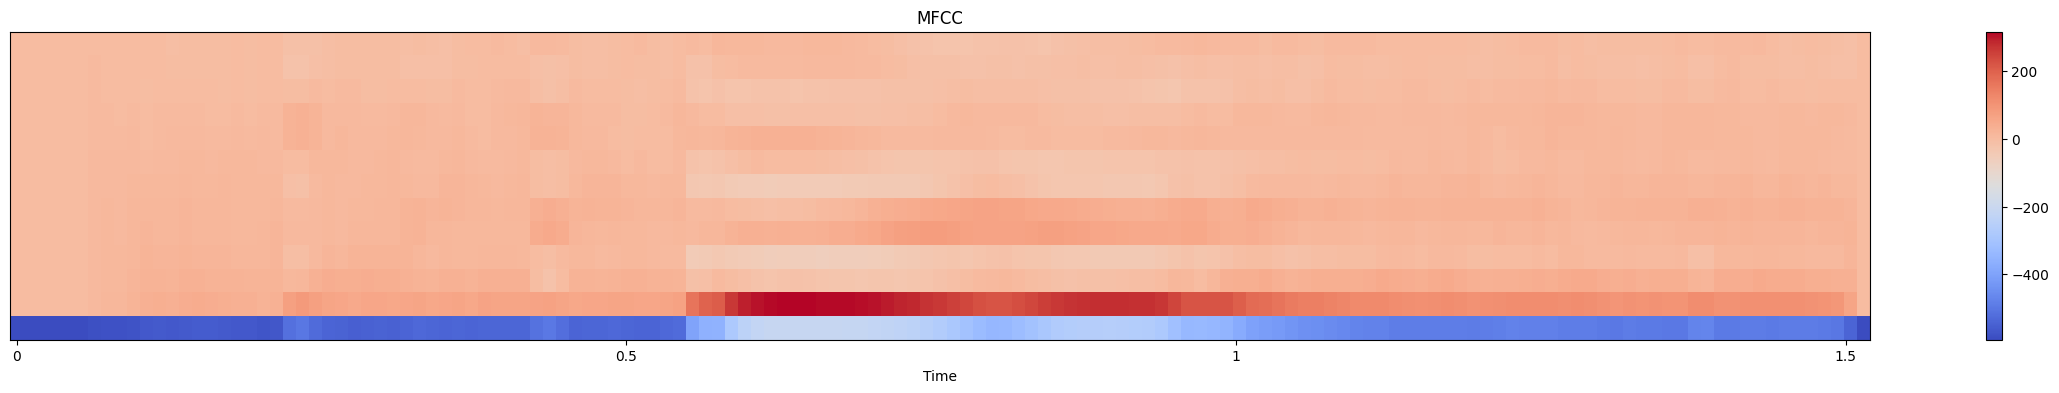

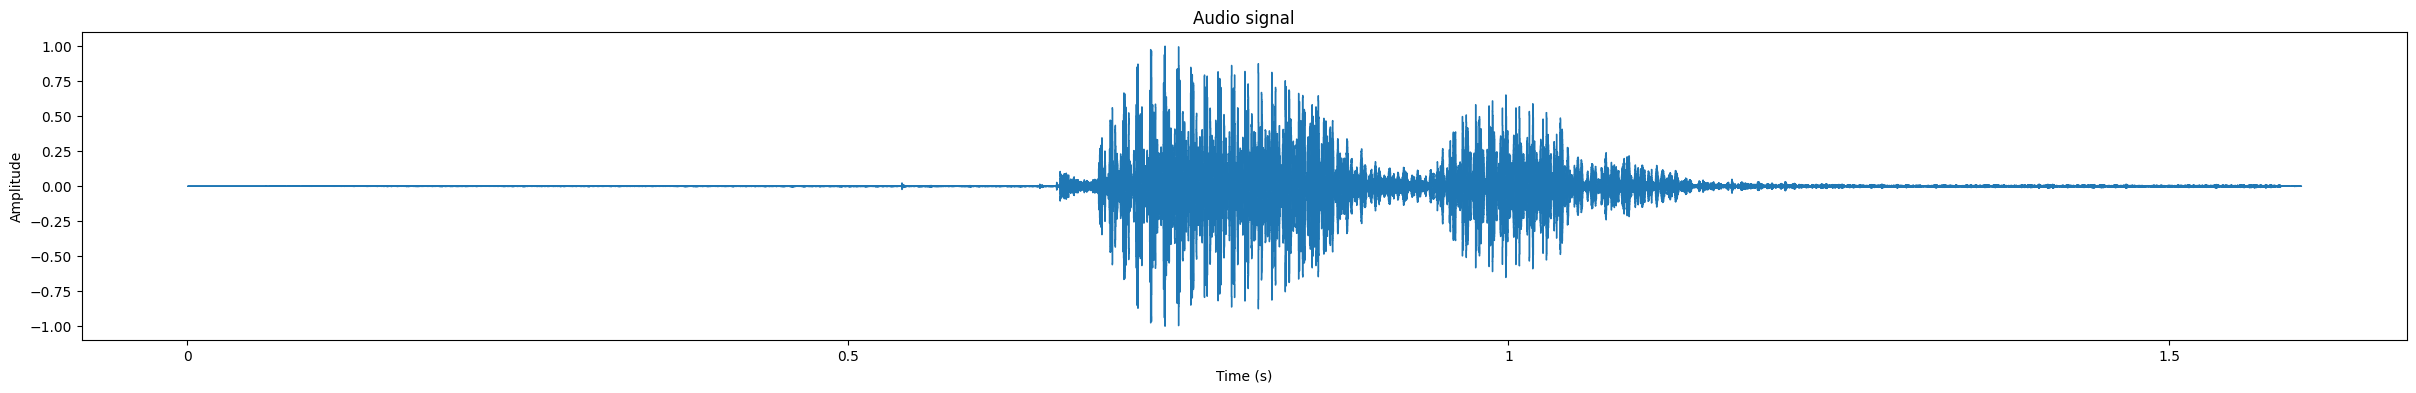

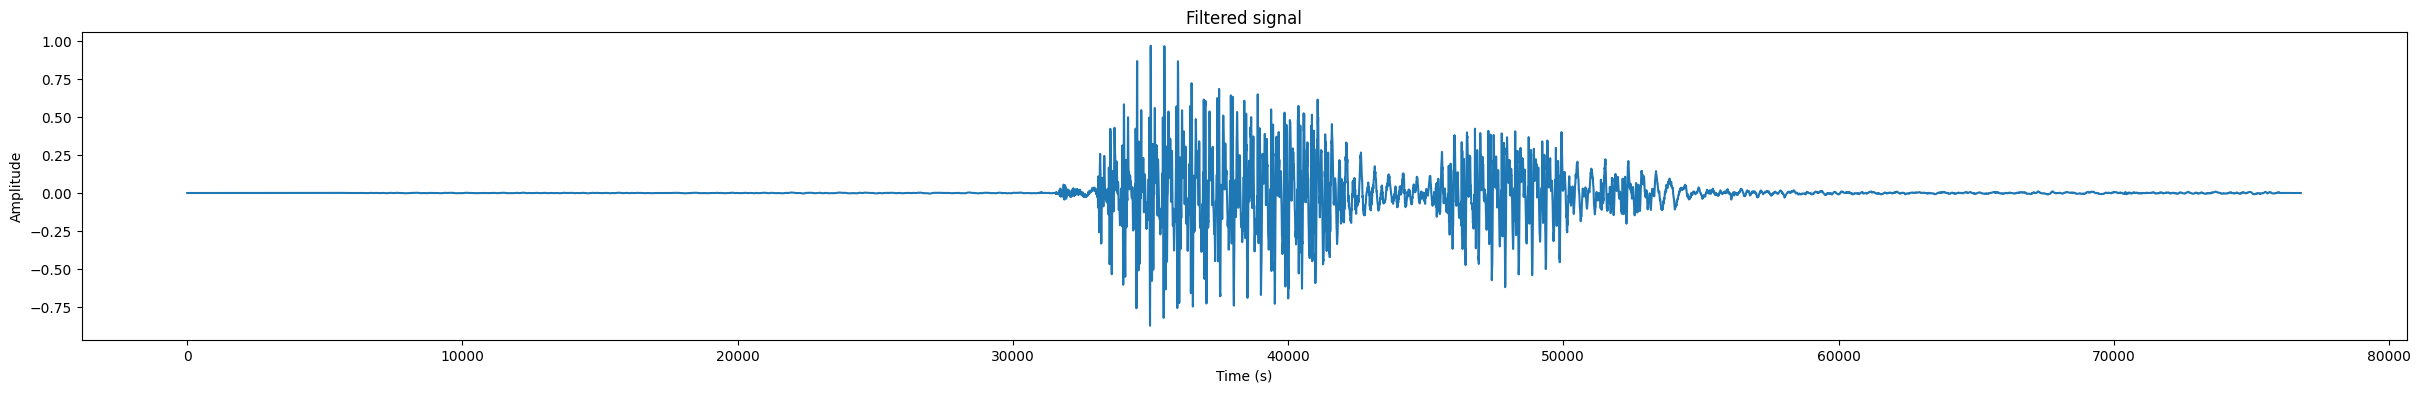

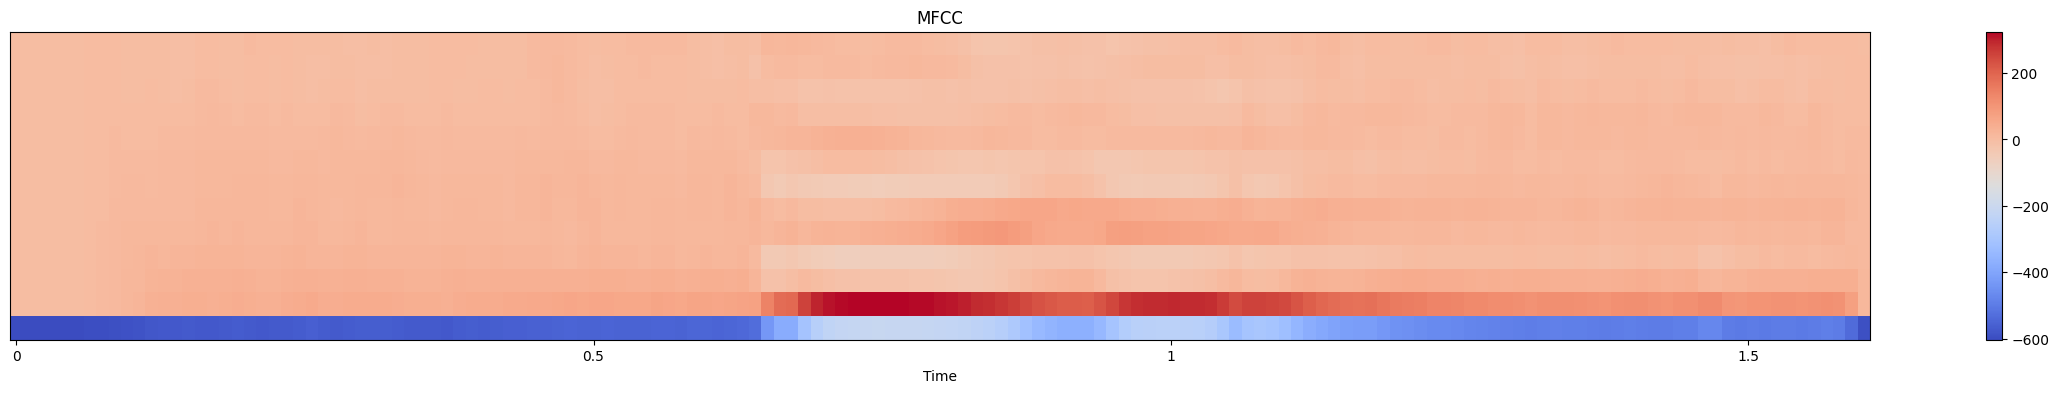

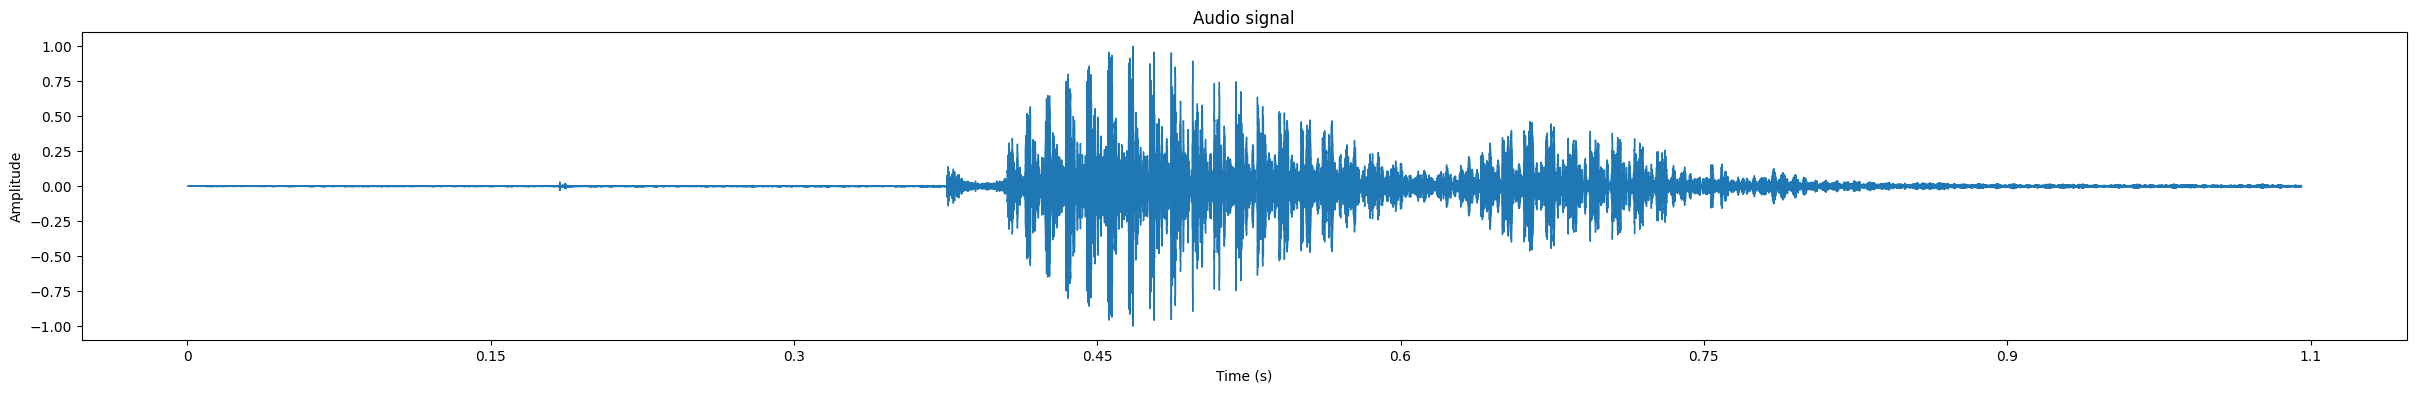

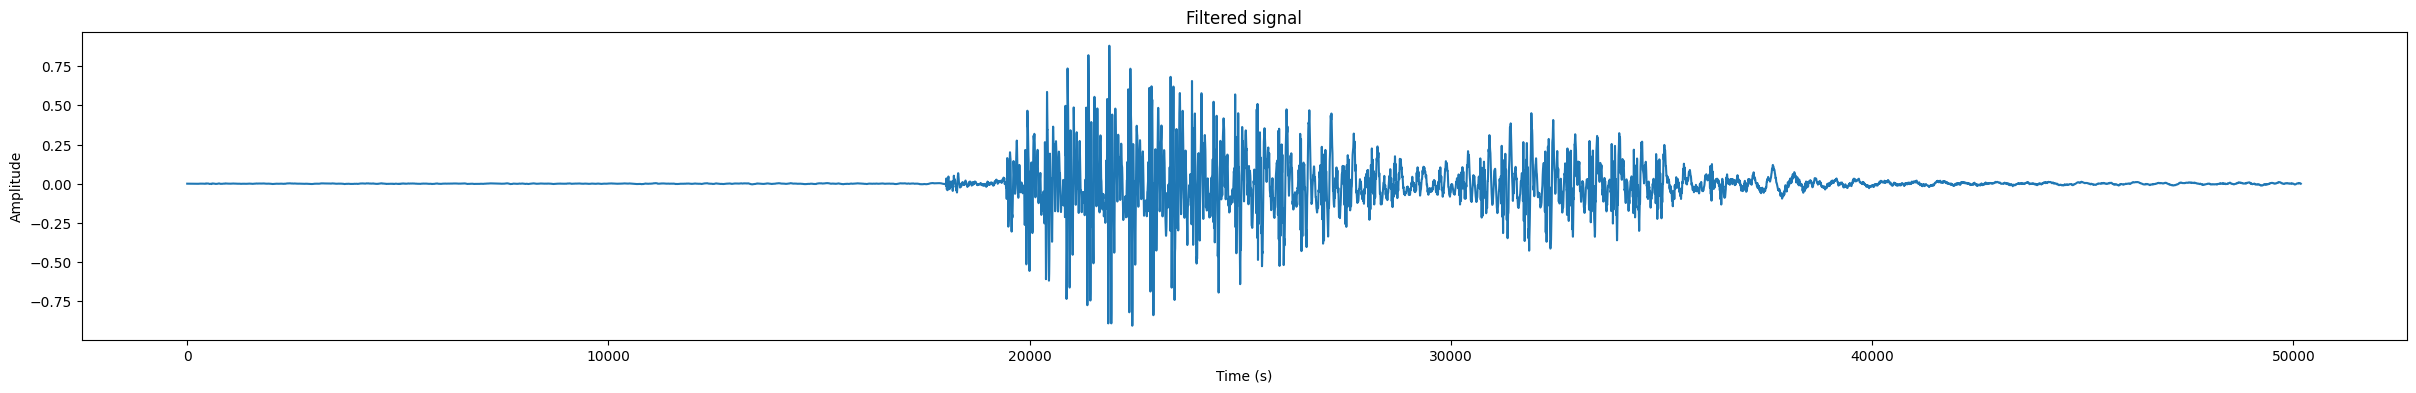

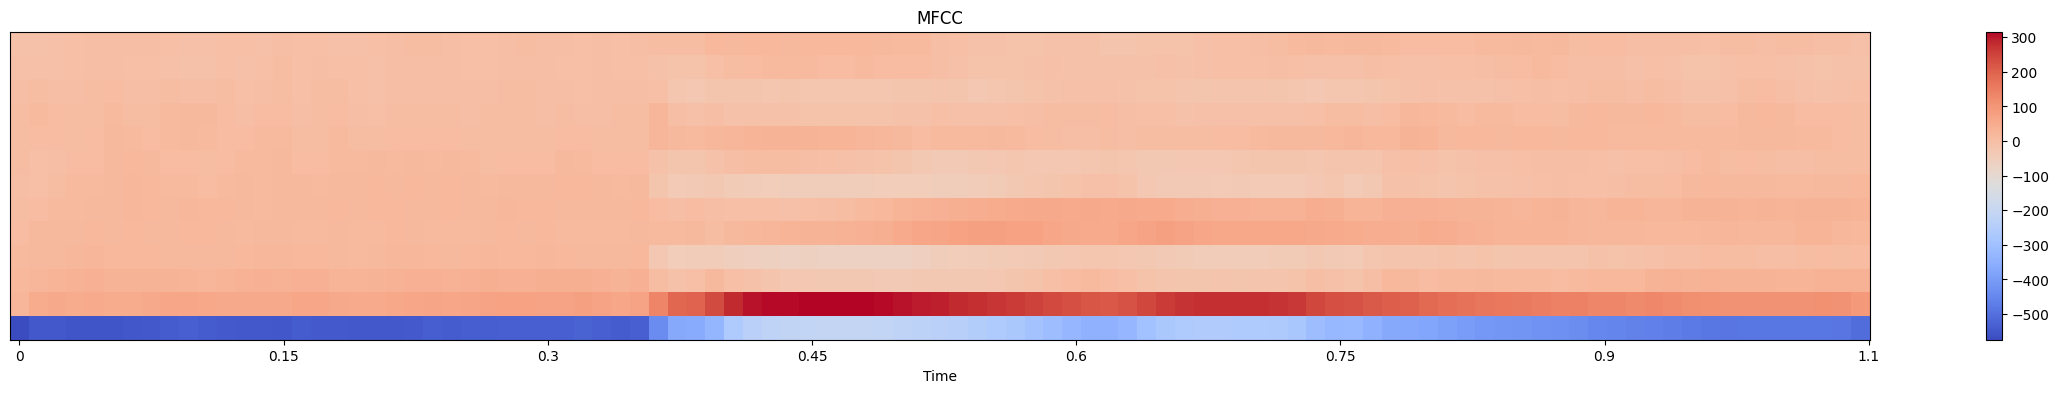

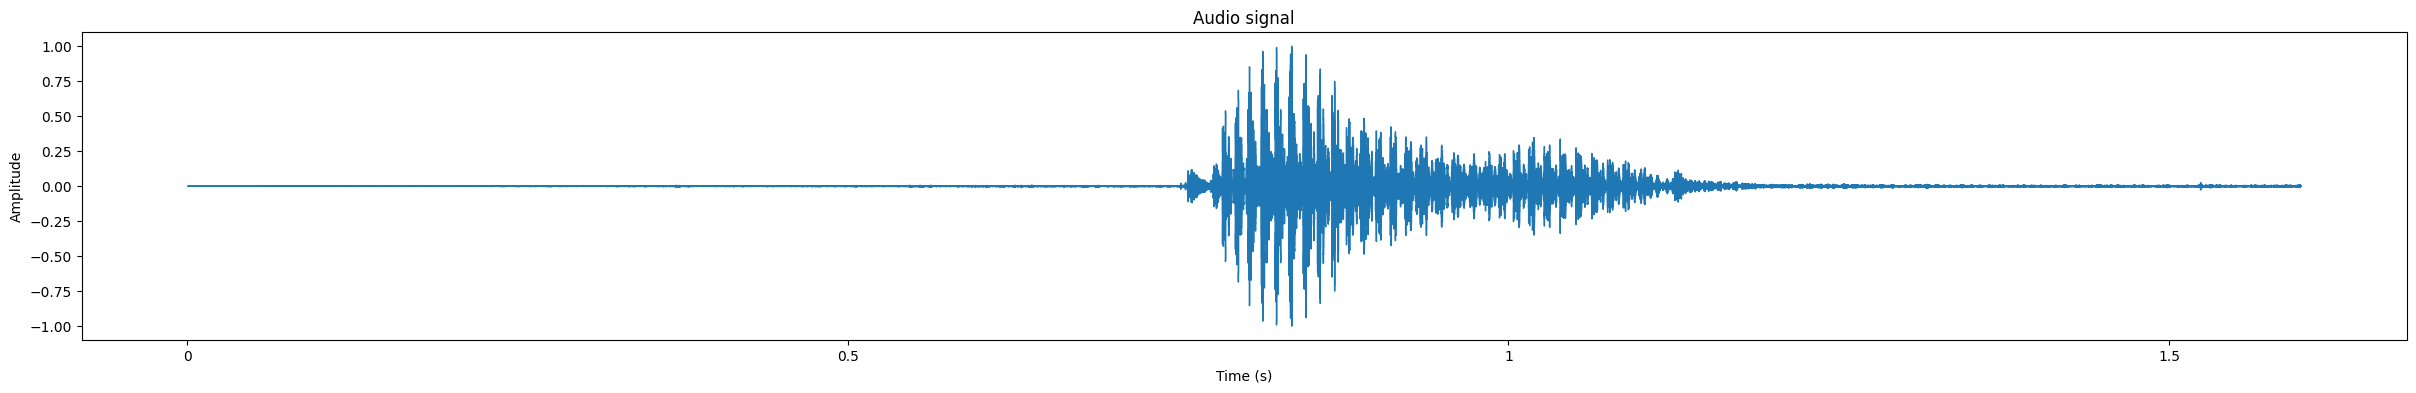

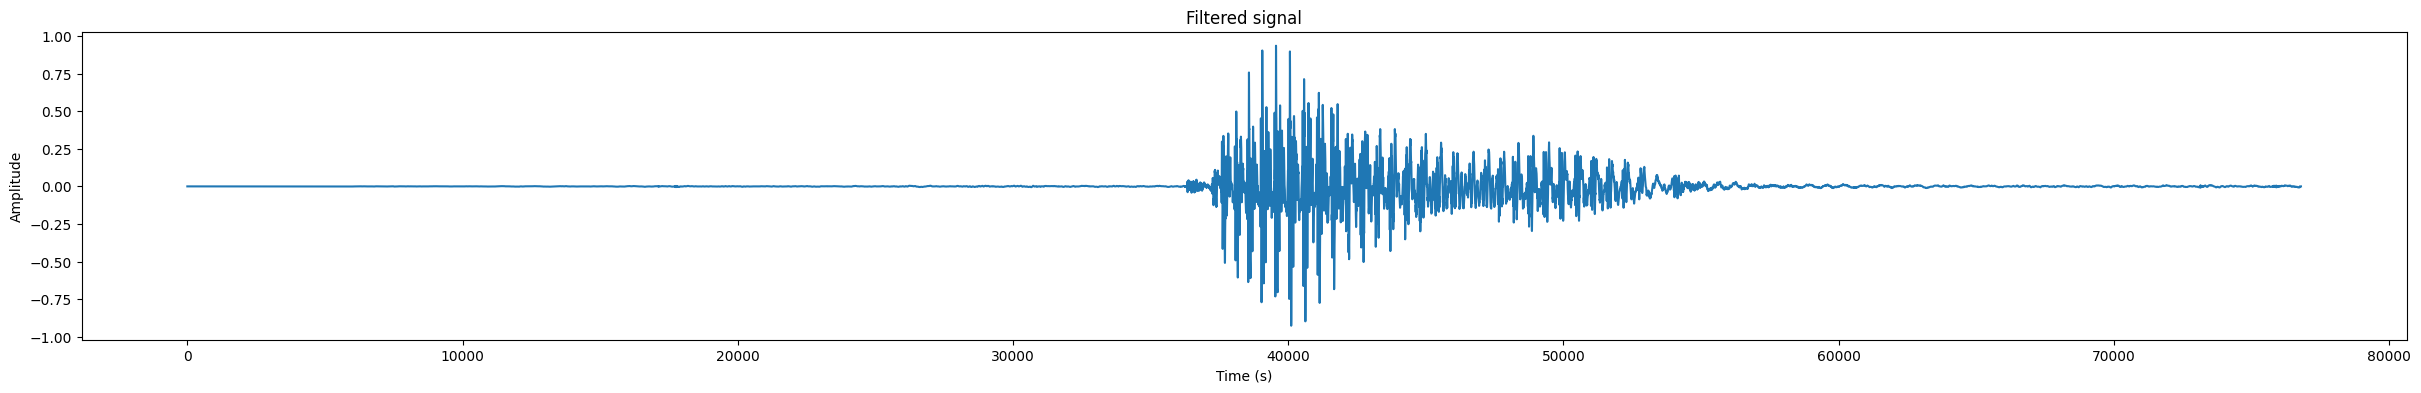

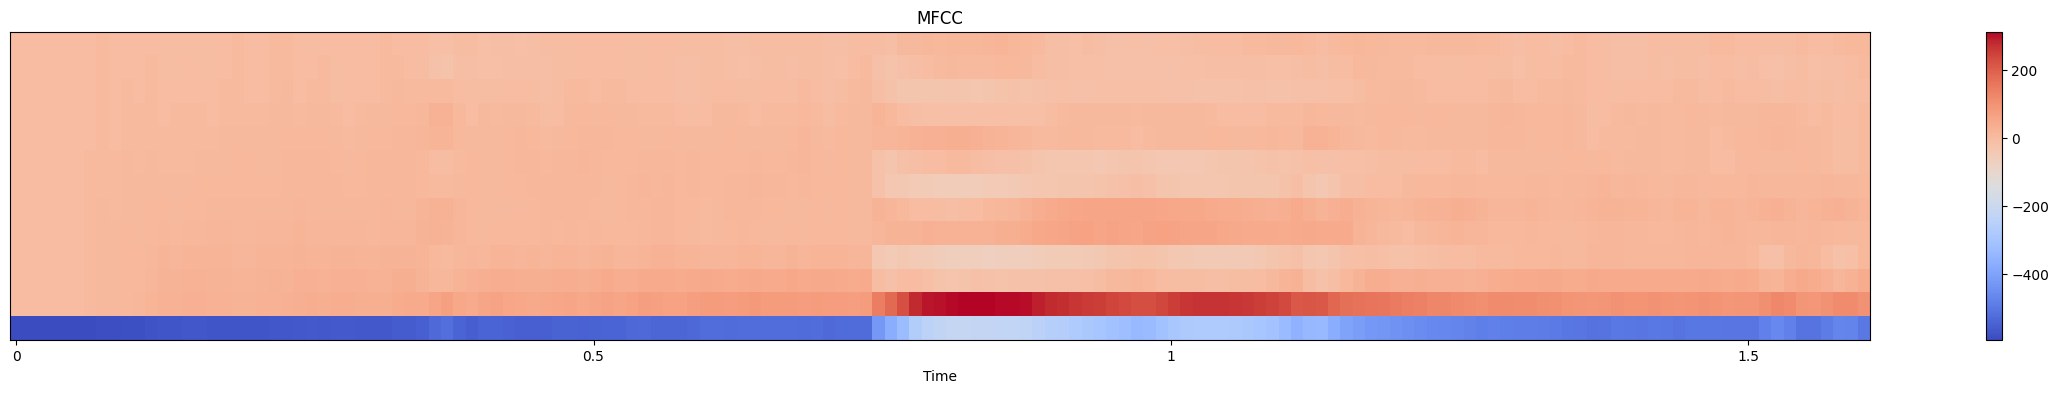

Arianna feature shape: (8, 13)
Andre feature shape: (9, 13)
Arianna labels shape: (8,)
Andre labels shape: (9,)


In [40]:
# Labels creation: Arianna (speaker_id = 0), André (speaker_id = 1)
arianna_features, arianna_labels = create_labels_and_features(arianna_files, speaker_id=0)
andre_features, andre_labels = create_labels_and_features(andre_files, speaker_id=1)

print("Arianna feature shape:", arianna_features.shape)
print("Andre feature shape:", andre_features.shape)

print("Arianna labels shape:", arianna_labels.shape)
print("Andre labels shape:", andre_labels.shape)

# Features unified
X = np.vstack([andre_features, arianna_features])  
y = np.hstack([andre_labels, arianna_labels])

Training set: 13
Test set: 4


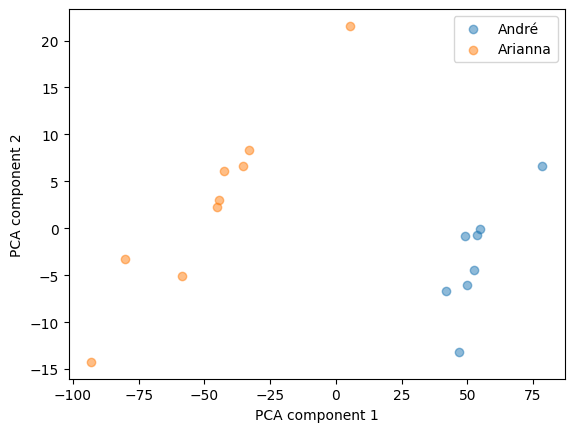

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# to divide dataset in training and test section (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]}")
print(f"Test set: {X_test.shape[0]}")


# PCA to reduce in 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], label='André', alpha=0.5)
plt.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], label='Arianna', alpha=0.5)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()
plt.show()


In [42]:
# to save the dataset in npz format
np.savez('speaker_dataset.npz', features=X, labels=y)

Option 1: Support Vector Machine

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# initialize and train the model
model = SVC(kernel='linear')  # linear or RBF
model.fit(X_train, y_train)

# evaluation on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


Option 2: Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

# initialize and train the model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# evaluation on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


Option 3: K-NN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# initialize and train the model
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)

# evaluation on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0
